In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from xgcm import Grid
import seawater
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import scipy
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pylab import cm
from scipy.stats import pearsonr
import matplotlib.patches as patches


os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
def xarray_rolling_trends(dat,pval=False,title='default',force=True,zarr=False,npp=False):
    print(f'Calculating trend ensemble for {title}')
    holder=[]
    pholder=[]
    for i in np.arange(0,5*12,1):
        tlen=17

        start_day_iter=np.datetime64('1998-01')+np.timedelta64(i,'M')
        end_day_iter=start_day_iter+np.timedelta64(tlen,'Y')
        iter_test=dat.sel(time=slice(start_day_iter,end_day_iter))#.load()
        data=xarray_get_trend(iter_test.chunk(dict(time=-1)))
        if pval==False:
            hh_iter=data.sel(parameter=0)*365#calculate_trend(iter_test)
            hh_iter.name=f'{start_day_iter} to {end_day_iter}'
            #if npp==True:
            #    print(f'saving {hh_iter}')
            #    hh_iter.to_netcdf(f'../processed_data/var_ensembles/npp_slices/npp_{hh_iter.name}.nc')
            #print(hh_iter.name)
            holder.append(hh_iter)
        elif pval==True:
            hh_iter_p=data.sel(parameter=3)#calculate_trend(iter_test)
            hh_iter_p.name=f'{start_day_iter} to {end_day_iter}'
            pholder.append(hh_iter_p)    
   
    if pval==True:
        p_time_period_ensemble=xr.concat(pholder,dim='timeperiod')
        return p_time_period_ensemble
    elif pval==False:
        time_period_ensemble=xr.concat(holder,dim='timeperiod')
        return time_period_ensemble

In [4]:
forcing=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_force_month.zarr.zip')
forcing=forcing.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
forcing=forcing.rename({'xt_ocean':'lon','yt_ocean':'lat'})

forcing['lon']=forcing['lon']+360
forcing['lon_x']=forcing['lon_x']+360

forcing=forcing.sel(lon=slice(120,290),lat=slice(-40,40))
forcing['time']=forcing.time.astype('datetime64[M]')

forcing=forcing.sel(time=slice('1998','2020')).sel(ensemble=25,method='nearest')

In [5]:
atmos=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/atmos_isobaric_month.zarr.zip')
#atmos['lon']=atmos['lon']+360
eqpac_atmos=atmos.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac_atmos['time']=eqpac_atmos.time.astype('datetime64[M]')
eqpac_atmos_u_v=eqpac_atmos.sel(ensemble=25)[['u_ref','v_ref']]
#eqpac_atmos=eqpac_atmos.load()
eqpac_atmos

<xarray.Dataset>
Dimensions:         (time: 731, ensemble: 96, level: 21, lat: 40, lon: 68)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * lat             (lat) float64 -39.44 -37.42 -35.39 ... 35.39 37.42 39.44
  * level           (level) float32 1.0 5.0 10.0 20.0 ... 850.0 925.0 1e+03
  * lon             (lon) float64 121.2 123.8 126.2 128.8 ... 283.8 286.2 288.8
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
Data variables: (12/37)
    DELP            (time, ensemble, level, lat, lon) float32 dask.array<chunksize=(1, 96, 21, 40, 68), meta=np.ndarray>
    awp             (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    evap            (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    h500            (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    hght            (time, ensemble, level, lat, lon) float32 dask.array<chunksize=(1, 96, 21, 40, 68), meta=np.ndarray>
    lwdn_sfc        (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    ...              ...
    u_ref           (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    ucomp           (time, ensemble, level, lat, lon) float32 dask.array<chunksize=(1, 96, 21, 40, 68), meta=np.ndarray>
    v_ref           (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    vcomp           (time, ensemble, level, lat, lon) float32 dask.array<chunksize=(1, 96, 21, 40, 68), meta=np.ndarray>
    vis_exopd_vl_c  (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
    wvp             (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 40, 68), meta=np.ndarray>
Attributes: (12/27)
    NCO:                        netCDF Operators version 4.7.8 (Homepage = ht...
    calendar:                    julian
    cm-enkf_source:             commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    comment:                    pressure level interpolator, version 3.0, pre...
    contact_name:               Decadal Activity 1 - Data Assimilation
    control_name:               c5
    ...                         ...
    model_source:               commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:         Atmosphere delta lat = 2.02degrees ; Atmosphe...
    perturbation_name:          not applicable
    references:                 OKane, T.J., Sandery, P.A., Monselesan, D.P.,...
    run_variant_name:           data assimilation
    title:                      AccessOcean-AM2

In [6]:
eqws = np.sqrt(eqpac_atmos['u_ref']**2+eqpac_atmos['v_ref']**2).sel(time=slice('1998','2020'))
eqws

<xarray.DataArray (time: 275, ensemble: 96, lat: 40, lon: 68)>
dask.array<getitem, shape=(275, 96, 40, 68), dtype=float32, chunksize=(1, 96, 40, 68), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * lat       (lat) float64 -39.44 -37.42 -35.39 -33.37 ... 35.39 37.42 39.44
  * lon       (lon) float64 121.2 123.8 126.2 128.8 ... 281.2 283.8 286.2 288.8
  * time      (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-11-01

In [7]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40))
phys_eqpac=phys_eqpac.sel(lon_x=slice(120,290),lat_x=slice(-40,40))
phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 731, ensemble: 96, st_ocean: 50, lat: 140,
                             lon: 170, sw_ocean: 50, lon_x: 171, lat_x: 141)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) datetime64[ns] 1960-01-01 ... 2020-11-01
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 120.0 121.0 122.0 ... 289.0 290.0
  * lat                     (lat) float64 -39.41 -38.44 -37.46 ... 38.38 39.34
  * lat_x                   (lat_x) float64 -39.9 -38.92 -37.95 ... 38.86 39.81
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 140, 171), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 141, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 141, 171), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [8]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140,
                      lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [9]:
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density_rev=cafe_potential_density.copy()
cafe_potential_density_rev['st_ocean']=cafe_potential_density_rev['st_ocean']*-1


In [180]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=32)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39645 instead
  warnings.warn(


In [182]:
cluster#.close()

In [13]:
#cluster.close()

In [14]:
forcing.pme_net

<xarray.DataArray 'pme_net' (time: 275, lat: 140, lon: 170)>
dask.array<getitem, shape=(275, 140, 170), dtype=float32, chunksize=(1, 140, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    coordinates:   geolon_t geolat_t
    long_name:     precip-evap into ocean (total w/ restore + normalize)
    units:         (kg/m^3)*(m/sec)
    valid_range:   [-1000000.0, 1000000.0]

In [15]:
# QUICK  FORCING TEST FOR SSH AND PME_NET
forcing=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_force_month.zarr.zip')
forcing=forcing.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
forcing=forcing.rename({'xt_ocean':'lon','yt_ocean':'lat'})

forcing['lon']=forcing['lon']+360
forcing['lon_x']=forcing['lon_x']+360

forcing=forcing.sel(lon=slice(120,290),lat=slice(-40,40))
forcing['time']=forcing.time.astype('datetime64[M]')

forcing=forcing.sel(time=slice('1998','2020')).sel(ensemble=25,method='nearest')

pme_ts=forcing.pme_net.sel(lat=slice(-5,5)).mean(['lat','lon']).load()

-0.08165387
0.005034231890022056
0.02763885640888475


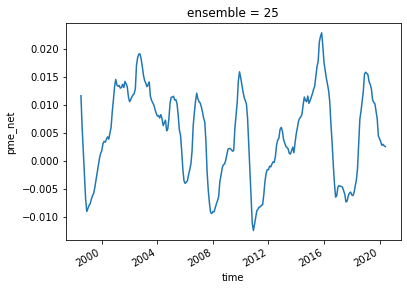

In [16]:
(pme_ts*1e3).rolling(time=12,center=True).mean().plot()
pme_ts_anom=(pme_ts-pme_ts.values[0])*1e3
print(pme_ts_anom.values[-1])
print(pme_ts.mean().values*1e3)
print(pme_ts.std().values*1e3)

# There is 5.2Sv into the Box ????
# NEed to correc this to years. 

In [17]:
# SSH
ssh=phys_eqpac.eta_t.sel(ensemble=25).sel(time=slice('1998-01-01','2020-01-01'),lat=slice(-5,5)).load()

0.10831651
0.39437434


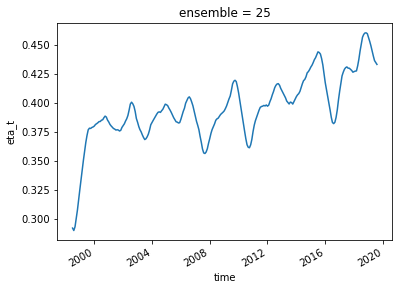

In [ ]:
ssh_ts=ssh.mean(['lat','lon'])
ssh_ts_anom=(ssh_ts-ssh_ts.values[0])#*1e6
print(ssh_ts_anom.values[-1])
print(ssh_ts.mean().values)
(ssh_ts).rolling(time=12,center=True).mean().plot()

In [20]:
extras=False
if extras==True:
    temp_tx=phys_eqpac.sel(lat=5,ensemble=25,method='nearest').sel(time=slice('1998-01-01','2020-01-01'))[['neutral_diffusion_temp','temp_vdiff_impl', 'neutral_gm_temp','temp_sponge_tend']]
    temp_tx_loaded=temp_tx.mean(dim='time').load()

    plt.subplot(221)
    temp_tx_loaded.neutral_diffusion_temp.plot()
    plt.ylim([1000,0])
    plt.subplot(222)
    temp_tx_loaded.temp_vdiff_impl.plot()
    plt.ylim([1000,0])
    plt.subplot(223)
    temp_tx_loaded.neutral_gm_temp.plot()
    plt.ylim([1000,0])
    plt.subplot(224)
    temp_tx_loaded.temp_sponge_tend.plot()
    plt.ylim([1000,0])
    plt.tight_layout()
    plt.show()

    # Mean at 5S 1998-2020
    print(temp_tx_loaded.neutral_diffusion_temp.mean().values)
    print(temp_tx_loaded.temp_vdiff_impl.mean().values)
    print(temp_tx_loaded.neutral_gm_temp.mean().values)
    print(temp_tx_loaded.temp_sponge_tend.mean().values)

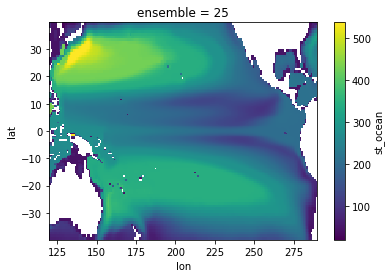

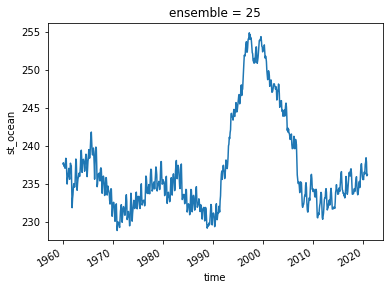

In [23]:
# Areas and grid depths
# Check Density Depths

adic=(eqpac.sel(ensemble=25)[['dic','adic']])
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

st_ocean_holder=adic.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

depths=st_ocean_holder.where(cafe_potential_density_rev.chunk('auto')<=1026.3)

depths.max(dim='st_ocean').mean(dim='time').plot()
plt.show()
depths.max(dim='st_ocean').mean(dim=['lat','lon']).plot()
plt.show()

In [24]:
# Shoaling between 1998 and 2020??
print(xarray_rolling_trend(depths.max(dim='st_ocean').sel(lat=slice(-5,5),time=slice('1998-01-01','2020-01-01')).mean(dim=['lat','lon'])))

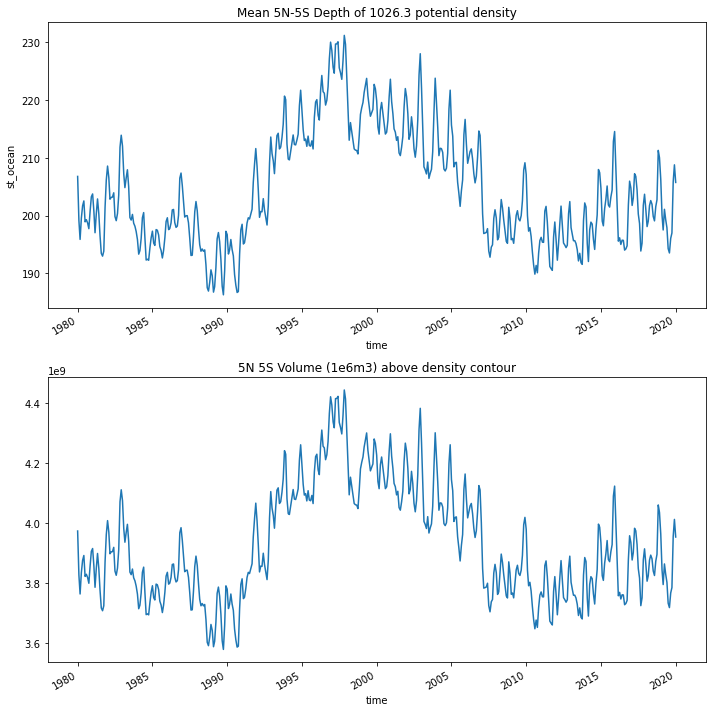

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(211)
depths.max(dim='st_ocean').sel(lat=slice(-5,5),time=slice('1980-01-01','2020-01-01')).mean(dim=['lat','lon']).plot()
plt.title('Mean 5N-5S Depth of 1026.3 potential density')
plt.subplot(212)

((depths.depth_diff*area_m2).where(cafe_potential_density_rev.chunk('auto')<=1026.3).sel(lat=slice(-5,5),time=slice('1980-01-01','2020-01-01')).sum(dim=['lat','lon','st_ocean'])/1e6).plot()
plt.title('5N 5S Volume (1e6m3) above density contour')
plt.tight_layout()

Text(0.5, 1.0, 'Volume (1e6m3) in box')

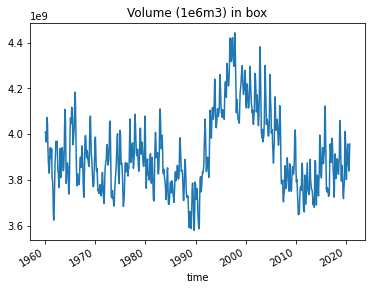

In [ ]:
((depths.depth_diff*area_m2).where(cafe_potential_density_rev.chunk('auto')<=1026.3).sel(lat=slice(-5,5)).sum(dim=['lat','lon','st_ocean'])/1e6).plot()
plt.title('Volume (1e6m3) in box')

In [26]:
#cafe_potential_density_rev.chunk('auto').where(cafe_potential_density_rev==1026.3)#,method='nearest')

In [27]:
eqpac

<xarray.Dataset>
Dimensions:          (time: 731, ensemble: 96, st_ocean: 50, lat: 140,
                      lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -39.41 -38.44 -37.46 ... 37.42 38.38 39.34
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 140, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 140, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [28]:
# RUN SAVE RICHARDSS CALCS




def load_richard_transports_CAFE60(ens=24,t1 = '1980-01-01',
                                    t2 = '2020-12-31',
                                    x1=-240, x2=-60,
                                    y1=-7, y2=7):

    file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
    file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
    file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
    file3='/home/mat236/area.nc'

    #dgrid=xr.open_dataset(file1)
    docn = xr.open_zarr(file1,consolidated=True)
    #darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    #darea

    dbgc = xr.open_zarr(file2)

    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    darea

    # create a thickness variable on the tracer depth grid
    mdepth=docn.st_ocean.copy()
    dbot=np.copy(docn.sw_ocean)
    dthick=dbot*0
    dthick[1:50]=dbot[1:50]-dbot[0:49]

    dthick[0]=dbot[0]
    #print(dthick,dbot)
    mdepth=mdepth*0+dthick
    mdepth


    adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    aco2=adic-dic




    cthickness=mdepth
    cthickness
    omask=(aco2[-1,0,:,:]*0).copy()
    cinv = aco2*cthickness*1e-3 #mmol to mols

    mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
    mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
    mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
    mcinv=cinv.sum(axis=1)+omask


    # RUN AND SAVE RICHARD TRANSPORTS


    vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

    tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


    tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

    # need to rename axis to work !! aco2_face=aco2.interp_like(tv)
    aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

    aco2_face


    trans_aco2 = aco2_face*tv
    trans_aco2_gm = aco2_face*tv_gm

    # CALC TU AS WELL AS TV

    tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
    aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
    trans_aco2_u = aco2_face_u*tu
    trans_aco2_u_gm = aco2_face_u*tu_gm


    direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
    print('saving tv')
    tv.to_netcdf(direc+'trans_v.nc')
    print('saving tv co2')
    trans_aco2.to_netcdf(direc+'trans_aco2_v.nc')
    print('saving tv co2 gm')
    trans_aco2_gm.to_netcdf(direc+'trans_aco2_v_gm.nc')
    print('saving tu')
    tu.to_netcdf(direc+'trans_u.nc')
    print('saving tu co2')
    trans_aco2_u.to_netcdf(direc+'trans_aco2_u.nc')
    print('saving tu co2_gm')
    trans_aco2_u_gm.to_netcdf(direc+'trans_aco2_u_gm.nc')


def load_richard_transports_CAFE60_2(ens=24,t1 = '1980-01-01',
                                    t2 = '2020-12-31',
                                    x1=-240, x2=-60,
                                    y1=-40.5, y2=40.5):

    file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
    file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
    file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
    file3='/home/mat236/area.nc'

    #dgrid=xr.open_dataset(file1)
    docn = xr.open_zarr(file1,consolidated=True)
    #darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    #darea

    dbgc = xr.open_zarr(file2)

    darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
    darea

    # create a thickness variable on the tracer depth grid
    mdepth=docn.st_ocean.copy()
    dbot=np.copy(docn.sw_ocean)
    dthick=dbot*0
    dthick[1:50]=dbot[1:50]-dbot[0:49]

    dthick[0]=dbot[0]
    #print(dthick,dbot)
    mdepth=mdepth*0+dthick
    mdepth


    adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    aco2=adic-dic




    cthickness=mdepth
    cthickness
    omask=(aco2[-1,0,:,:]*0).copy()
    cinv = aco2*cthickness*1e-3 #mmol to mols

    mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
    mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
    mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
    mcinv=cinv.sum(axis=1)+omask


    # RUN AND SAVE RICHARD TRANSPORTS


    vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

    tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
    tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
    tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


    tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

    # need to rename axis to work !! aco2_face=aco2.interp_like(tv)
    aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

    aco2_face


    trans_aco2 = aco2_face*tv
    trans_aco2_gm = aco2_face*tv_gm

    # CALC TU AS WELL AS TV

    tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
    aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
    trans_aco2_u = aco2_face_u*tu
    trans_aco2_u_gm = aco2_face_u*tu_gm


    direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
    print('saving tv')
    tv.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_v_400.nc')
    print('saving tv co2')
    #trans_aco2.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_v_400.nc')
    print('saving tv co2 gm')
    #trans_aco2_gm.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_v_gm_400.nc')
    print('saving tu')
    #tu.to_netcdf(direc+'trans_u.nc')
    print('saving tu co2')
    #trans_aco2_u.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_u_400.nc')
    print('saving tu co2_gm')
    #trans_aco2_u_gm.sel(st_ocean=slice(0,400)).to_netcdf(direc+'trans_aco2_u_gm_400.nc')



In [29]:
cluster#.close()

In [30]:
save_richard_numbers=False
save_richard_numbers1=False
if save_richard_numbers==True:
    load_richard_transports_CAFE60()
    
if save_richard_numbers1==True:
    load_richard_transports_CAFE60_2()

In [31]:
gr=xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
gr=gr[['ds_00_02_T','ds_20_22_T','ds_02_22_T','ds_00_20_T']]
gr=gr.rename({'grid_x_T':'lon','grid_y_T':'lat'})
gr['lon']=gr['lon']+360
gr_slice=gr.sel(lon=slice(120,290),lat=slice(-40,40))#
lon_face_length_m=gr_slice.ds_00_02_T
lat_face_length_m=gr_slice.ds_20_22_T

In [32]:
# LOAD ENSO

#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 1998.
#all_dates=all_dates.where(all_dates.time>=np.datetime64('1998-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time>np.datetime64('1998-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #1998 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

def add_enso_colours(ax):
    #Put in the ENSO box regions
    #ep_events and cp events
    
    #ensofps=['../processed_data/indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv']
    #ensofps=['../processed_data//indexes/el_nino_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv','../processed_data//indexes/cold_cp_events.csv']
    #ensofps=['../processed_data//indexes/ep_events.csv','../processed_data//indexes/la_nina_events.csv','../processed_data//indexes/cp_events.csv']
    ensofps=['../processed_data/indexes/ep_events_ch2.csv','../processed_data/indexes/la_nina_events_ch2.csv','../processed_data/indexes/cp_events_ch2.csv']
   
    for whichenso,fp in enumerate(ensofps):
        events=pd.read_csv(fp)
        for ev in events.iterrows():
            endm=np.datetime64(ev[1].end).astype('datetime64[M]')
            endm1=endm-np.timedelta64(1,'M')
            endm2=endm+np.timedelta64(1,'M')
            start=np.datetime64(ev[1].start).astype('datetime64[M]')
          
            if start==endm1: #We don't want to plot events that last for only a month
                pass    
            #elif start==endm2-np.timedelta64(1,'M'): #There was some weirdness with the 2015 event not being continuous, and this fixes it..,
            #    pass
            else:
                if whichenso==0:
                    #if el nino
                    patchcol='darkred'#'firebrick'
                elif whichenso==1:
                    #if la nina
                    patchcol='deepskyblue'
                elif whichenso==2:
                    patchcol='darkorange'
                elif whichenso==3:
                    patchcol='navy'
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
                rect=patches.Rectangle((start,-25),endm-start,50,linewidth=0,alpha=0.3,color=patchcol)
                ax.add_patch(rect)
    return True

In [33]:
# Areas and grid depths

adic=(eqpac.sel(ensemble=25)[['dic','adic']])
area=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area['xt_ocean']=area['xt_ocean']+360
area['xu_ocean']=area['xu_ocean']+360
area_m2=area.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

st_ocean_holder=adic.st_ocean
l=0
depth_diffs=[]
# Calcualate the m between depths so we can integrate
for i,x in enumerate(st_ocean_holder.st_ocean):
    d=x.values-l
    l=x.values
    #print(d)#x.values)
    depth_diffs.append(d)
    
st_ocean_holder=st_ocean_holder.assign_coords(
    depth_diff=('st_ocean', depth_diffs))

In [34]:
# Calc Canth Accumulation
LoadAndSave='load'#'save=Load from gadi and save, load=Load from saved file, gadi=load from gadi

if LoadAndSave=='save':
    raw_carbon_1980=adic.sel(time=slice('1980-01-01','2020-01-01'),lat=slice(-6,6)).load().chunk('auto') #CHECK LOAD
    raw_carbon_1980.to_netcdf('datasets/raw_carbon_aug16.nc')
elif LoadAndSave=='gadi':
     raw_carbon_1980=adic.sel(time=slice('1980-01-01','2020-01-01'),lat=slice(-6,6)).load().chunk('auto') #CHECK LOAD
elif LoadAndSave=='load':
    raw_carbon_1980=xr.open_dataset('datasets/raw_carbon_aug16.nc')
    
raw_carbon_1980

<xarray.Dataset>
Dimensions:   (time: 481, st_ocean: 50, lat: 36, lon: 170)
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-01-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -5.834 -5.5 -5.167 -4.833 ... 4.833 5.167 5.5 5.834
Data variables:
    dic       (time, st_ocean, lat, lon) float32 ...
    adic      (time, st_ocean, lat, lon) float32 ...
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Nov  5 17:19:53 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [35]:
#raw_carbon_1980=xr.open_dataset('datasets/raw_carbon_aug16.nc')#.__xarray_dataarray_variable__

In [36]:
#raw_carbon

In [37]:

raw_carbon=raw_carbon_1980.sel(time=slice('1998-01-01','2020-01-01'))
raw_carbon_area=raw_carbon*area_m2*st_ocean_holder.depth_diff
anth_c_area=(raw_carbon_area.adic-raw_carbon_area.dic)#.chunk('auto')
raw_carbon_area_1980=raw_carbon_1980*area_m2*st_ocean_holder.depth_diff
anth_c_area_1980=raw_carbon_area_1980.adic-raw_carbon_area_1980.dic
print('loaded1')

raw_anth_c=raw_carbon.adic-raw_carbon.dic
raw_anth_c_1980=raw_carbon_1980.adic-raw_carbon_1980.dic

loaded1


In [38]:
anth_c_area

<xarray.DataArray (time: 265, st_ocean: 50, lat: 36, lon: 170)>
array([[[[9.72944835e+11, 9.76512614e+11, 9.78402673e+11, ...,
                     nan,            nan,            nan],
         [9.74669742e+11, 9.77246618e+11, 9.77262346e+11, ...,
                     nan,            nan,            nan],
         [9.74680228e+11, 9.76090563e+11,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.95507569e+11, 1.01051793e+12, 1.01635588e+12, ...,
                     nan,            nan,            nan],
         [9.95140567e+11, 1.01289296e+12, 1.01798117e+12, ...,
                     nan,            nan,            nan],
         [9.95381740e+11, 1.01478564e+12, 1.01927092e+12, ...,
                     nan,            nan,            nan]],

        [[1.94719515e+12, 1.95480781e+12, 1.95842015e+12, ...,
                     nan,            nan,            nan],
         [1.95055059e+12, 1.95683156e+12, 1.95594551e+12, ...,
                     nan,            nan,            nan],
         [1.95087041e+12, 1.95484451e+12,            nan, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-01-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -5.834 -5.5 -5.167 -4.833 ... 5.167 5.5 5.834
    ensemble    int32 25
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [39]:
#adic_concentrations.sel(lon=120,method='nearest').interp(lat=tu.lat)
# We need to do the conversion AND rename the cols and possibly fix the lons to same coord system.
# * 1e6 *1e-15*12*1e-3 * 86400 *365
def fix_xuyu(dat):
    try:
        dat=dat.rename({'xu_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yu_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xt_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass
    try:
        dat=dat.rename({'xu_ocean':'lon','yt_ocean':'lat'})
        print('renamed')
    except:
        pass 
    try:
        dat=dat.rename({'xu_ocean':'lon'})
        print('renamed')
    except:
        pass 
    
    dat['time']=dat.time.astype('datetime64[M]')

    dat['lon']=dat['lon']+360
    #dat['lon_x']=dat['lon_x']+360
    return dat


# RICHARDS NUMBERS??? Overwrite so we can do a test. Need to do conversion though??
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
tv=xr.open_dataset(direc+'trans_v.nc').ty_trans.chunk('auto')
tv_400=xr.open_dataset(direc+'trans_v_400.nc').ty_trans.chunk('auto')

tv_canth=xr.open_dataset(direc+'trans_aco2_v.nc').__xarray_dataarray_variable__.chunk('auto')
tv_canth_gm=xr.open_dataset(direc+'trans_aco2_v_gm.nc').__xarray_dataarray_variable__.chunk('auto')

tv_canth_400=xr.open_dataset(direc+'trans_aco2_v_400.nc').__xarray_dataarray_variable__.chunk('auto')
tv_canth_gm_400=xr.open_dataset(direc+'trans_aco2_v_gm_400.nc').__xarray_dataarray_variable__.chunk('auto')

tu=xr.open_dataset(direc+'trans_u.nc').tx_trans.chunk('auto')
tu_canth=xr.open_dataset(direc+'trans_aco2_u.nc').__xarray_dataarray_variable__.chunk('auto')
tu_canth_gm=xr.open_dataset(direc+'trans_aco2_u_gm.nc').__xarray_dataarray_variable__.chunk('auto')


tu=fix_xuyu(tu)
tu_canth=fix_xuyu(tu_canth)* 1e6 *1e-15*12*1e-3 * 86400 *365
tu_canth_gm=fix_xuyu(tu_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365
tu_canth=tu_canth.drop('lon').rename({'xu_ocean':'lon'})
tu_canth_gm=tu_canth_gm.drop('lon').rename({'xu_ocean':'lon'})
tu_canth['lon']=tu_canth['lon']+360
tu_canth_gm['lon']=tu_canth_gm['lon']+360


tv=fix_xuyu(tv)
tv_400=fix_xuyu(tv_400)
tv_canth=fix_xuyu(tv_canth)* 1e6 *1e-15*12*1e-3 * 86400 *365
tv_canth_gm=fix_xuyu(tv_canth_gm)* 1e6 *1e-15*12*1e-3 * 86400 *365

tv_canth_400=fix_xuyu(tv_canth_400)* 1e6 *1e-15*12*1e-3 * 86400 *365
tv_canth_gm_400=fix_xuyu(tv_canth_gm_400)* 1e6 *1e-15*12*1e-3 * 86400 *365

renamed
renamed
renamed
renamed
renamed
renamed
renamed
renamed
renamed


In [41]:
# Quick EUC Cross Sections and trends???

euc_canth=(tu_canth+tu_canth_gm)/12/365/24/60/60*1e18
euc_sv=tu

euc_canth['st_ocean']=euc_canth['st_ocean']*-1
euc_sv['st_ocean']=euc_sv['st_ocean']*-1

In [43]:
st_ocean_holder_rev=st_ocean_holder.copy()
st_ocean_holder_rev['st_ocean']=st_ocean_holder_rev['st_ocean']*-1

In [44]:
raw_anth_c_rev=raw_anth_c.copy()
raw_anth_c_rev['st_ocean']=raw_anth_c_rev['st_ocean']*-1

## Pittman STC Figure 4

Calculating trend ensemble for default
Calculating trend ensemble for default
Calculating trend ensemble for default
Calculating trend ensemble for default
Calculating trend ensemble for default
Calculating trend ensemble for default


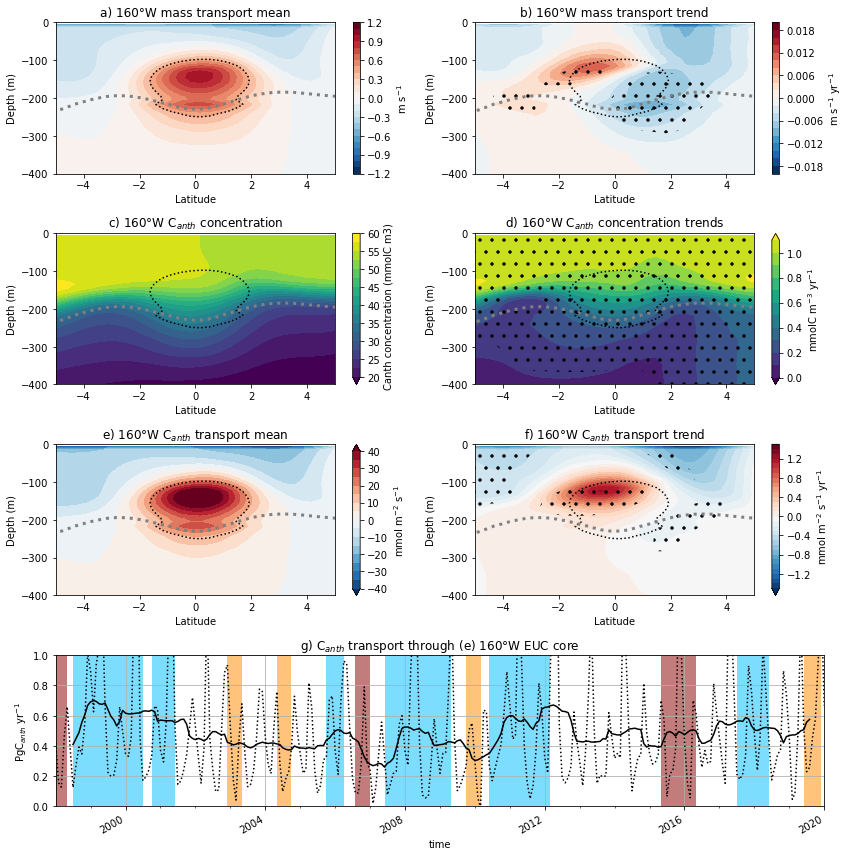

In [47]:
# THIS IS THE REAL FINAL FIGURE
plt.figure(figsize=(12,12))

iso_contours=[1023,1024.5,1026.3]
iso_contours=[1026.3]

euc_contour_200=((euc_sv/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').sel(st_ocean=slice(0,-500))
euc_contour_240=((euc_sv/lat_face_length_m.sel(lon=240,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=240,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').sel(st_ocean=slice(0,-500))
euc_canth_200=(euc_canth.sel(lon=240,method='nearest')/lat_face_length_m.sel(lon=240,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff).sel(time=slice('1998-01-01','2020-01-01')).sel(st_ocean=slice(0,-500))
euc_contour_200_core=((euc_sv/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=200,method='nearest').sel(st_ocean=slice(0,-500))


plt.subplot(421)
((euc_sv.sel(time=slice('1998-01-01','2020-01-01'))/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=200,method='nearest').mean(dim='time').sel(st_ocean=slice(0,-500)).plot.contourf(cbar_kwargs={'label':'m s$^{-1}$'},levels=np.arange(-1.2,1.3,0.1))
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)    
plt.title('a) 160°W mass transport mean')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])




plt.subplot(422)
xarray_rolling_trends(((euc_sv.sel(time=slice('1998-01-01','2020-01-01'))/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=200,method='nearest').sel(st_ocean=slice(0,-500))).mean(dim='timeperiod').plot.contourf(levels=np.arange(-0.02,0.022,0.002),cbar_kwargs={'label':'m s$^{-1}$ yr$^{-1}$'})
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)

datt=xarray_rolling_trends(euc_sv.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest').chunk(dict(time=-1)),pval=True).sel(st_ocean=slice(0,-500)).mean(dim='timeperiod')
cnt=plt.contourf(datt.lat,datt.st_ocean,datt,colors='none',hatches=['.'],levels=[0,0.05])
for c in cnt.collections:
        c.set_edgecolor("face")
        
        
plt.title('b) 160°W mass transport trend')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])




plt.subplot(423)

raw_anth_c_rev.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',levels=np.arange(20,62.5,2.5),cbar_kwargs={'label':'Canth concentration (mmolC m3)'})
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')

plt.title('c) 160°W C$_{anth}$ concentration')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])


plt.subplot(424)
xarray_rolling_trends(raw_anth_c_rev.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest').chunk(dict(time=-1))).mean(dim='timeperiod').plot.contourf(levels=np.arange(0,1.2,0.1),cmap='viridis',cbar_kwargs={'label':'mmolC m$^{-3}$ yr$^{-1}$'})#(cmap='viridis',levels=np.arange(0,75,2.5))
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')

datt=xarray_rolling_trends(raw_anth_c_rev.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest').chunk(dict(time=-1)),pval=True).mean(dim='timeperiod')
cnt=plt.contourf(datt.lat,datt.st_ocean,datt,colors='none',hatches=['.'],levels=[0,0.05])



plt.title('d) 160°W C$_{anth}$ concentration trends')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])





plt.subplot(425)
(euc_canth.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest')/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff).mean(dim='time').sel(st_ocean=slice(0,-500)).plot.contourf(levels=np.arange( -40,45,5),cbar_kwargs={'label':'mmol m$^{-2}$ s$^{-1}$'})
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)
plt.title('e) 160°W C$_{anth}$ transport mean')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])

plt.subplot(426)
#xarray_rolling_trends((euc_canth.sel(lon=180,method='nearest')/lat_face_length_m.sel(lon=180,method='nearest')/st_ocean_holder_rev.depth_diff).chunk(dict(time=-1))).sel(st_ocean=slice(0,-500)).mean(dim='timeperiod').plot()
xarray_rolling_trends((euc_canth.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01'))/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff).sel(st_ocean=slice(0,-500)).chunk(dict(time=-1))).mean(dim='timeperiod').plot.contourf(levels=np.arange(-1.5,1.6,0.1),cbar_kwargs={'label':'mmol m$^{-2}$ s$^{-1}$ yr$^{-1}$'})
euc_contour_200.plot.contour(levels=[0.4],colors='k',linestyles=':')
(cafe_potential_density).sel(lon=200,method='nearest').sel(time=slice('1998-01-01','2020-01-01')).mean(dim='time').plot.contour(levels=iso_contours,colors='gray',linestyles=":",linewidths=3)

datt=xarray_rolling_trends((euc_canth.sel(time=slice('1998-01-01','2020-01-01')).sel(lon=200,method='nearest')/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff).sel(st_ocean=slice(0,-500)).chunk(dict(time=-1)),pval=True).mean(dim='timeperiod')
cnt=plt.contourf(datt.lat,datt.st_ocean,datt,colors='none',hatches=['.'],levels=[0,0.05])


plt.title('f) 160°W C$_{anth}$ transport trend')
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.ylim([-400,0])
plt.xlim([-5,5])



ax=plt.subplot(414)
euc_contour_core_canth=(euc_canth_200.sel(time=slice('1997-01-01','2020-01-01')).where(euc_contour_200_core>=0.4)).sel(st_ocean=slice(-50,-300),lat=slice(-3,3)).sum(dim=['lat','st_ocean'])*1e6*1e-18*12*86400*365
euc_contour_core_canth.rolling(time=12,center=True).mean().plot(c='k')
euc_contour_core_canth.plot(c='k',linestyle=':')
#plt.legend(['12 Month rolling mean','Unfiltered seasonal cycle'],ncol=2)
plt.title('g) C$_{anth}$ transport through (e) 160°W EUC core')
plt.ylim([0,1])
plt.xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
add_enso_colours(ax)

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
plt.grid()


plt.tight_layout()

In [48]:
# Calc Canth Accumulation
LoadAndSave_LARGE='load'#'save=Load from gadi and save, load=Load from saved file, gadi=load from gadi

if LoadAndSave_LARGE=='save':
    raw_carbon_large=adic.sel(time=slice('1998-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400)).load() #CHECK LOAD
    raw_carbon_large.to_netcdf('datasets/LARGE_raw_carbon_aug16.nc')
elif LoadAndSave_LARGE=='gadi':
    raw_carbon_large=adic.sel(time=slice('1998-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400)).load() #CHECK LOAD
elif LoadAndSave_LARGE=='load':
    raw_carbon_large=xr.open_dataset('datasets/LARGE_raw_carbon_aug16.nc')#.__xarray_dataarray_variable__

In [49]:

# Calc Canth Accumulation
#raw_carbon_large=adic.sel(time=slice('1998-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400)).load() #CHECK LOAD
#raw_carbon_large=raw_carbon_large.sel(time=slice('1998-01-01','2020-01-01'),lat=slice(-40.5,40.5),st_ocean=slice(0,400))#.load() #CHECK LOAD
#raw_carbon_large=xr.open_dataset('datasets/LARGE_raw_carbon_aug16.nc')#.__xarray_dataarray_variable__
raw_anth_c_large=raw_carbon_large.adic-raw_carbon_large.dic
#raw_anth_c_large_1980=raw_carbon_large_1980.adic-raw_carbon_large.dic

#raw_carbon_area_large=raw_carbon_large*area_m2*st_ocean_holder.sel(st_ocean=slice(0,400)).depth_diff
#anth_c_area_large=raw_carbon_area_largeadic-raw_carbon_area_large.dic
#anth_c_area     #mmol m3
anth_c_area     #mmol m3

<xarray.DataArray (time: 265, st_ocean: 50, lat: 36, lon: 170)>
array([[[[9.72944835e+11, 9.76512614e+11, 9.78402673e+11, ...,
                     nan,            nan,            nan],
         [9.74669742e+11, 9.77246618e+11, 9.77262346e+11, ...,
                     nan,            nan,            nan],
         [9.74680228e+11, 9.76090563e+11,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.95507569e+11, 1.01051793e+12, 1.01635588e+12, ...,
                     nan,            nan,            nan],
         [9.95140567e+11, 1.01289296e+12, 1.01798117e+12, ...,
                     nan,            nan,            nan],
         [9.95381740e+11, 1.01478564e+12, 1.01927092e+12, ...,
                     nan,            nan,            nan]],

        [[1.94719515e+12, 1.95480781e+12, 1.95842015e+12, ...,
                     nan,            nan,            nan],
         [1.95055059e+12, 1.95683156e+12, 1.95594551e+12, ...,
                     nan,            nan,            nan],
         [1.95087041e+12, 1.95484451e+12,            nan, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time        (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-01-01
  * lon         (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat         (lat) float64 -5.834 -5.5 -5.167 -4.833 ... 5.167 5.5 5.834
    ensemble    int32 25
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0

In [50]:
# Calc Canth CO2 flux
adic_co2flux=(eqpac.sel(ensemble=25)['stf10']-eqpac.sel(ensemble=25)['stf07']).sel(lat=slice(-5,5),time=slice('1980-01-01','2020-01-01'))
adic_co2flux_area=adic_co2flux*area_m2
adic_co2flux_area_loaded=adic_co2flux_area.load()
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1998','2020')).sum(['lat','lon']).rolling(time=12,center=True).mean())*12*60*60*24*365)/1e18
co2_seasonal=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1998','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

In [51]:
co2_80=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1980','2020')).sum(['lat','lon']).rolling(time=12,center=True).mean())*12*60*60*24*365)/1e18

In [52]:
co2=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1998','2020')).sum(['lat','lon']).rolling(time=12,center=True).mean())*12*60*60*24*365)/1e18
co2_rolling=(((adic_co2flux_area_loaded).sel(lat=slice(-5,5),time=slice('1998','2020')).sum(['lat','lon']).rolling(time=12,center=True).mean())*12*60*60*24*365)/1e18

In [53]:
co2=(((adic_co2flux_area_loaded.chunk('auto')).sel(lat=slice(-5,5),time=slice('1998','2020')).sum(['lat','lon']))*12*60*60*24*365)/1e18

In [58]:
# QUICK FACE TESTS

In [59]:
N_face_tx=tv_canth.sel(lat=5,method='nearest')
N_face_tx_3=tv_canth.sel(lat=3,method='nearest')
N_face_tx_gm=tv_canth_gm.sel(lat=5,method='nearest')
N_face_tx_3_gm=tv_canth_gm.sel(lat=3,method='nearest')

S_face_tx=tv_canth.sel(lat=-5,method='nearest')
S_face_tx_3=tv_canth.sel(lat=-3,method='nearest')
S_face_tx_gm=tv_canth_gm.sel(lat=-5,method='nearest')
S_face_tx_3_gm=tv_canth_gm.sel(lat=-3,method='nearest')

S_face_tx_small=tv_canth.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')
S_face_tx_gm_small=tv_canth_gm.sel(lon=slice(145,300)).sel(lat=-5,method='nearest')

E_face_tx=tu_canth.sel(lon=120,method='nearest')
E_face_tx_gm=tu_canth_gm.sel(lon=120,method='nearest')

In [60]:
ntx=-N_face_tx.sum(['lon','st_ocean'])
stx=S_face_tx.sum(['lon','st_ocean'])
stx_small=S_face_tx_small.sum(['lon','st_ocean'])

etx=E_face_tx.sum(['lat','st_ocean'])

ntx_gm=-N_face_tx_gm.sum(['lon','st_ocean'])
stx_gm=S_face_tx_gm.sum(['lon','st_ocean'])
stx_gm_small=S_face_tx_gm_small.sum(['lon','st_ocean'])

etx_gm=E_face_tx_gm.sum(['lat','st_ocean'])


itf_canth=(tu_canth.sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm=(tu_canth_gm.sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [61]:
(tu_canth.sel(lon=120,method='nearest').sum(['st_ocean','lat']))* 1e6 *1e-15*12*1e-3 * 86400 *365

<xarray.DataArray '__xarray_dataarray_variable__' (time: 491)>
dask.array<mul, shape=(491,), dtype=float64, chunksize=(126,), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2020-11-01
    lon       float64 120.0

In [62]:
cluster#.close()

In [65]:
def plot_cartopy_row(dat,
                     axn,
                     sb1=2,
                     sb2=2,
                     levs=None,
                     lon='lon',lat='lat',title=None,cmap='RdBu_r',extend=None,units=''):
                     
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth

    fr=0.03
    fs=12
    ms=10
    
    
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    f=ax.contourf(dat[lon].values,dat[lat].values,dat,transform=ccrs.PlateCarree(),cmap=cmap,levels=levs,extend=extend) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.axhline(5,c='k')
    ax.axhline(-5,c='k')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
    ax.set_title(title)
    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr)
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

In [66]:
# Need to trim or shorten
def linear_trend(ax,x,y):#,xlab,ylab,diagonal_line=1,printer=1,plot=1,logspace=0,color=np.ndarray(0),zx=np.ndarray(0),zy=np.ndarray(0),trendline=1):
    """"
    Designed for chlorophyll trends <1mg/m3 
    
    Given an x and y (same size)
    + Title, X Label, Y Label
    
    if Z, will plot 
    Optional: Diagonal_line=0, default on.
    Optional: Printer=0, default on
    
    Returns linear statistics. 
    """
    
    x1=np.ravel(x)
    y=np.ravel(y)
    mask=~np.isnan(x1)
    x=x[mask]
    y=y[mask]
    x2=x1.astype('datetime64[D]')
    slope, intercept, r_value, p_value, std_err = linregress(pd.to_numeric(x2),y)
    #if plot==0:
    #     return slope, intercept, r_value, p_value, std_err 
    
    mn=min(pd.to_numeric(x2))
    mx=max(pd.to_numeric(x2))
    x2=np.linspace(mn,mx,len(x2))
    y1=slope*pd.to_numeric(x2)+intercept
    plt.plot(x,y1,'r:',linewidth=2)  
     
    return slope, intercept, r_value, p_value

## Pittman STC Tables 1 and 2 in the following ~30 cells?
### For Table also need CO2 flux and Accumulation rates / yr

In [68]:
# TABLE?
# Load Regions? 
# ADDED ROLLING TO THE VARIABLES AUG 13

# CHECK WHICH VARS INPUT!
varz_mean=[tv.rolling(time=12,center=True).mean(),
           tv_canth.rolling(time=12,center=True).mean(),
           ((tv_canth+tv_canth_gm)).rolling(time=12,center=True).mean()]

region_mask=xr.open_dataset('new_calculations/region_mask_new.nc').sortby('lat') #region_mask_may12
region_mask['st_ocean']=region_mask['st_ocean']*-1
region_mask=region_mask.load()
region_mask#.close()#mask['st_ocean']=mask.st_ocean*-1 # mask will need a bit of fixing (where =1)

# TABLE?
ev=[None,neutral_events,ep_events,cp_events,nina_events]
evName=['Alltime','Neutral','EP','CP','La Nina']

In [69]:
#method='std' # or mean
region_mask['south_wbc_subsurface']=xr.concat([region_mask.south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_wbc_subsurface']=xr.concat([region_mask.north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['south_shallowwbc_subsurface']=xr.concat([region_mask.shallow_south_wbc,region_mask.south_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()
region_mask['north_shallowwbc_subsurface']=xr.concat([region_mask.shallow_north_wbc,region_mask.north_subsurface],dim='regions').max(dim='regions')#.sel(lat=-5,method='nearest').mean(dim='time').plot()

In [70]:
masksN=[region_mask.north_subsurface,region_mask.north_surface,region_mask.north_wbc,region_mask.shallow_north_wbc,region_mask.north_wbc_subsurface,region_mask.north_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
masksS=[region_mask.south_subsurface,region_mask.south_surface,region_mask.south_wbc,region_mask.shallow_south_wbc,region_mask.south_wbc_subsurface,region_mask.south_shallowwbc_subsurface,region_mask.above_isopycnal,None]#,None,None]
direction=[5,-5,'convergence']
dir_names=['5N','5S','Convergence']
mask_names=['Subsurface','Surface','WBC','ShallowWBC','WBC+Interior','ShallowWBC+Interior','Above Isotherm','Full Depth']#'positive','negative']

varz=varz_mean
method='mean' #'total #Syn #std
var_names=['Meridional Transport','AnthC transport','AnthC+GM transport']#,'C transport','adic','adic_accumulation']

In [71]:
#tv
depth_reg_1=region_mask.south_surface.sel(lat=-5,method='nearest')
depth_reg_2=region_mask.north_surface.sel(lat=5,method='nearest')

print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon'])+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon'])).mean(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon'])+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon'])).std(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon']).mean(dim='time').values)+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon']).mean(dim='time').values)
print((tv.sel(lat=-5,method='nearest').where(depth_reg_1==1).sum(dim=['st_ocean','lon']).std(dim='time').values)+-tv.sel(lat=5,method='nearest').where(depth_reg_2==1).sum(dim=['st_ocean','lon']).std(dim='time').values)


-44.53067
13.987208
-44.53067
-2.5207615


In [72]:
cluster

In [73]:
#nina_events#ev

In [74]:
#masksS

In [75]:
run_table=False
if run_table==True:
    for method in ['mean','rollingtrend','trend_pval','std','trend']:
        df_holder=[]
        for iENSO,enso_dates in enumerate(ev):
            enso_name=evName[iENSO]
            for var_i,data_type in enumerate(varz):

                data_type=data_type.sel(time=slice('1998','2020'))
                if enso_dates is not None:
                    data_type=data_type.sel(time=enso_dates)


                df_row_holder=[]
                for i,NS in enumerate(direction):
                    assert(len(masksN)==len(masksS)) # TEST TO MAKE SURE NO ISSUE. Only keen on index can manually do it later
                    mask_holder=masksN    
                    for depth_i,depth_region in enumerate(mask_holder):

                        data_type_s=data_type.sel(lon=slice(145,300)) 
                        if i==0: # North
                            #mask_holder=masksN
                            #data_type=data_type*-1
                            d=-data_type.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon'])

                        elif i==1: # South
                            #mask_holder=masksS
                            # REMOVE ITF FROM S FACE
                            d=data_type_s.sel(lat=NS,method='nearest').sum(dim=['st_ocean','lon'])
                        elif i==2: #convergence
                            d=(data_type_s.sel(lat=direction[1],method='nearest').sum(dim=['st_ocean','lon'])+\
                                -data_type.sel(lat=direction[0],method='nearest').sum(dim=['st_ocean','lon']))


                        var_name=var_names[var_i]
                        depth_name=mask_names[depth_i]
                        direction_name = dir_names[i]



                        if depth_name=='Full Depth':
                            if method=='mean':
                                ans=d.mean(dim='time').values
                            elif method=='std':
                                ans=d.std(dim='time').values
                            elif method=='trend':
                                 ans=xarray_get_trend(d.chunk(dict(time=-1))).sel(parameter=0).values      
                            elif method=='trend_pval':
                                 ans=xarray_rolling_trends(d.chunk(dict(time=-1)),pval=True).mean(dim='timeperiod').values 
                            elif method=='rollingtrend':
                                ans=xarray_rolling_trends(d.chunk(dict(time=-1))).mean(dim='timeperiod').values


                            #elif method=='sum':
                            #    d=data_type.sel(lat=NS,method='nearest').sum(dim='time').sum().values


                        if mask_holder[depth_i] is not None:
                            depth_reg_s=masksS[depth_i].sel(lat=-5,method='nearest')        
                            depth_reg_n=masksN[depth_i].sel(lat=5,method='nearest')      

                            if i==2:#'convergence':    #convergence 
                                #if depth_name=='Surface':
                                #    breakkkkkkkk
                                d1=(data_type_s.sel(lat=-5,method='nearest').where(depth_reg_s==1).sum(dim=['st_ocean','lon'])+\
                                    -data_type.sel(lat=5,method='nearest').where(depth_reg_n==1).sum(dim=['st_ocean','lon']))

                            elif i==1:#:NS==-5:
                                d1=data_type_s.sel(lat=NS,method='nearest').where(depth_reg_s==1).sum(dim=['st_ocean','lon'])
                            elif i==0:#NS==5:
                                d1=-data_type.sel(lat=NS,method='nearest').where(depth_reg_n==1).sum(dim=['st_ocean','lon'])


                            if method=='mean': 
                                ans=d1.mean(dim='time').values

                                #if depth_name=='WBC+Interior':
                                #    breakkkknow
                            elif method=='std': 
                                ans=d1.std(dim='time').values
                            elif method=='trend':
                                # DO TREND
                                ans=xarray_get_trend(d1.chunk(dict(time=-1))).sel(parameter=0).values
                            elif method=='trend_pval':
                                 ans=xarray_rolling_trends(d.chunk(dict(time=-1)),pval=True).mean(dim='timeperiod').values 
                            elif method=='rollingtrend':
                                # DO TREND
                                ans=xarray_rolling_trends(d1.chunk(dict(time=-1))).mean(dim='timeperiod').values



                            #elif method=='sum': 
                             #   d=data_type.sel(lat=NS,method='nearest').where(depth_reg==1).sum(dim='time').sum().values


                        #print(f'{var_name} {direction_name} {depth_name} {enso_name} {method} {ans}')

                        df_row_holder.append(pd.DataFrame(data={var_name:ans},index=pd.MultiIndex.from_tuples([(depth_name,direction_name,enso_name)])))

                        #pd.DataFrame({title:name={depth_name} 

                    df_holder.append(pd.concat(df_row_holder))


        tab=pd.concat(df_holder,axis=0,join='outer')#.dropna(thresh=10,axis=1)
        table1=tab.groupby(level=[0,1,2]).mean()
        table1.to_csv(f'transport_numbers_{method}_july12.csv')
    table1

In [76]:
table=pd.read_csv('transport_numbers_mean_july12.csv',index_col=[0,1,2])
tablestd=pd.read_csv('transport_numbers_std_july12.csv',index_col=[0,1,2])
tabletrends=pd.read_csv('transport_numbers_trend_july12.csv',index_col=[0,1,2])
tablerollingtrends_pval=pd.read_csv('transport_numbers_trend_pval_july12.csv',index_col=[0,1,2])
tablerollingtrends=pd.read_csv('transport_numbers_rollingtrend_july12.csv',index_col=[0,1,2])

table.reset_index().query("level_2=='Alltime'")#['AnthC+GM transport']

level_0      level_1  level_2  Meridional Transport  \
0         Above Isotherm           5N  Alltime             -8.175112   
5         Above Isotherm           5S  Alltime              3.769849   
10        Above Isotherm  Convergence  Alltime             -4.405263   
15            Full Depth           5N  Alltime             -2.477508   
20            Full Depth           5S  Alltime             13.510034   
25            Full Depth  Convergence  Alltime             11.032526   
30            ShallowWBC           5N  Alltime              7.502293   
35            ShallowWBC           5S  Alltime             12.842227   
40            ShallowWBC  Convergence  Alltime             20.344520   
45   ShallowWBC+Interior           5N  Alltime             12.789349   
50   ShallowWBC+Interior           5S  Alltime             28.278266   
55   ShallowWBC+Interior  Convergence  Alltime             41.067615   
60            Subsurface           5N  Alltime              5.287056   
65            Subsurface           5S  Alltime             15.436039   
70            Subsurface  Convergence  Alltime             20.723095   
75               Surface           5N  Alltime            -20.964461   
80               Surface           5S  Alltime            -24.508417   
85               Surface  Convergence  Alltime            -45.472878   
90                   WBC           5N  Alltime              8.900815   
95                   WBC           5S  Alltime             23.436384   
100                  WBC  Convergence  Alltime             32.337200   
105         WBC+Interior           5N  Alltime             14.187872   
110         WBC+Interior           5S  Alltime             38.872423   
115         WBC+Interior  Convergence  Alltime             53.060294   

     AnthC transport  AnthC+GM transport  
0          -0.193629           -0.192404  
5           0.098941            0.089430  
10         -0.094687           -0.102975  
15         -0.168178           -0.167847  
20          0.215251            0.208092  
25          0.047073            0.040246  
30          0.145603            0.145617  
35          0.243356            0.243249  
40          0.388959            0.388866  
45          0.253667            0.276827  
50          0.578751            0.585696  
55          0.832418            0.862523  
60          0.108064            0.131210  
65          0.335394            0.342447  
70          0.443458            0.473657  
75         -0.447296           -0.469232  
80         -0.479809           -0.496266  
85         -0.927105           -0.965498  
90          0.173030            0.172970  
95          0.354785            0.352793  
100         0.527815            0.525763  
105         0.281094            0.304181  
110         0.690179            0.695240  
115         0.971274            0.999421

In [77]:
abs(tablestd).reset_index().query("level_2=='Alltime'")

level_0      level_1  level_2  Meridional Transport  \
0         Above Isotherm           5N  Alltime             30.138235   
5         Above Isotherm           5S  Alltime             20.413462   
10        Above Isotherm  Convergence  Alltime             24.372625   
15            Full Depth           5N  Alltime              2.914008   
20            Full Depth           5S  Alltime              2.781506   
25            Full Depth  Convergence  Alltime              4.791528   
30            ShallowWBC           5N  Alltime              7.262651   
35            ShallowWBC           5S  Alltime              4.667093   
40            ShallowWBC  Convergence  Alltime              9.586344   
45   ShallowWBC+Interior           5N  Alltime             20.381678   
50   ShallowWBC+Interior           5S  Alltime             14.881547   
55   ShallowWBC+Interior  Convergence  Alltime             17.537584   
60            Subsurface           5N  Alltime             18.764359   
65            Subsurface           5S  Alltime             12.945171   
70            Subsurface  Convergence  Alltime             17.840193   
75               Surface           5N  Alltime             12.196518   
80               Surface           5S  Alltime              8.790627   
85               Surface  Convergence  Alltime             13.010590   
90                   WBC           5N  Alltime             11.222039   
95                   WBC           5S  Alltime              4.436151   
100                  WBC  Convergence  Alltime             14.119419   
105         WBC+Interior           5N  Alltime             21.662006   
110         WBC+Interior           5S  Alltime             13.497491   
115         WBC+Interior  Convergence  Alltime             20.807802   

     AnthC transport  AnthC+GM transport  
0           0.638446            0.637602  
5           0.452034            0.453336  
10          0.547145            0.546804  
15          0.650218            0.649551  
20          0.401023            0.402055  
25          0.554224            0.552902  
30          0.164013            0.163996  
35          0.097774            0.097758  
40          0.208488            0.208452  
45          0.423266            0.427257  
50          0.329500            0.322275  
55          0.394821            0.396599  
60          0.379944            0.385447  
65          0.286495            0.280752  
70          0.387783            0.394036  
75          0.273975            0.266148  
80          0.197100            0.201442  
85          0.305169            0.297759  
90          0.185788            0.185758  
95          0.094614            0.094743  
100         0.235324            0.235328  
105         0.432785            0.436425  
110         0.317491            0.310789  
115         0.413747            0.416042

In [78]:
abs(tablestd).reset_index().query("level_2=='Alltime'").groupby('level_0').sum().round(3)

# NEED To calculate these standard deviations on the timeseries. (DONT ADD UP)

Meridional Transport  AnthC transport  AnthC+GM transport
level_0                                                                       
Above Isotherm                     74.924            1.638               1.638
Full Depth                         10.487            1.605               1.605
ShallowWBC                         21.516            0.470               0.470
ShallowWBC+Interior                52.801            1.148               1.146
Subsurface                         49.550            1.054               1.060
Surface                            33.998            0.776               0.765
WBC                                29.778            0.516               0.516
WBC+Interior                       55.967            1.164               1.163

In [79]:
tablestd.reset_index().query("level_1=='Convergence'").query("level_2=='Alltime'")##.round(3)#.groupby('level_0').sum().round(3)

level_0      level_1  level_2  Meridional Transport  \
10        Above Isotherm  Convergence  Alltime             24.372625   
25            Full Depth  Convergence  Alltime              4.791528   
40            ShallowWBC  Convergence  Alltime              9.586344   
55   ShallowWBC+Interior  Convergence  Alltime             17.537584   
70            Subsurface  Convergence  Alltime             17.840193   
85               Surface  Convergence  Alltime             13.010590   
100                  WBC  Convergence  Alltime             14.119419   
115         WBC+Interior  Convergence  Alltime             20.807802   

     AnthC transport  AnthC+GM transport  
10          0.547145            0.546804  
25          0.554224            0.552902  
40          0.208488            0.208452  
55          0.394821            0.396599  
70          0.387783            0.394036  
85          0.305169            0.297759  
100         0.235324            0.235328  
115         0.413747            0.416042

In [80]:
(tabletrends*365).reset_index().query("level_2=='Alltime'")

level_0      level_1  level_2  Meridional Transport  \
0         Above Isotherm           5N  Alltime             -0.051197   
5         Above Isotherm           5S  Alltime             -0.266237   
10        Above Isotherm  Convergence  Alltime             -0.317435   
15            Full Depth           5N  Alltime              0.028706   
20            Full Depth           5S  Alltime             -0.083852   
25            Full Depth  Convergence  Alltime             -0.055146   
30            ShallowWBC           5N  Alltime             -0.135664   
35            ShallowWBC           5S  Alltime             -0.203149   
40            ShallowWBC  Convergence  Alltime             -0.338813   
45   ShallowWBC+Interior           5N  Alltime             -0.100283   
50   ShallowWBC+Interior           5S  Alltime             -0.290894   
55   ShallowWBC+Interior  Convergence  Alltime             -0.391177   
60            Subsurface           5N  Alltime              0.035381   
65            Subsurface           5S  Alltime             -0.087746   
70            Subsurface  Convergence  Alltime             -0.052365   
75               Surface           5N  Alltime              0.049086   
80               Surface           5S  Alltime              0.024657   
85               Surface  Convergence  Alltime              0.073743   
90                   WBC           5N  Alltime             -0.211661   
95                   WBC           5S  Alltime             -0.143343   
100                  WBC  Convergence  Alltime             -0.355004   
105         WBC+Interior           5N  Alltime             -0.176280   
110         WBC+Interior           5S  Alltime             -0.231089   
115         WBC+Interior  Convergence  Alltime             -0.407369   

     AnthC transport  AnthC+GM transport  
0          -0.005741           -0.005713  
5          -0.004182           -0.004534  
10         -0.009924           -0.010246  
15         -0.003648           -0.003676  
20         -0.002712           -0.002842  
25         -0.006360           -0.006518  
30         -0.000254           -0.000254  
35         -0.000036           -0.000045  
40         -0.000289           -0.000299  
45          0.002276            0.003024  
50          0.004689            0.004860  
55          0.006965            0.007884  
60          0.002529            0.003278  
65          0.004724            0.004905  
70          0.007254            0.008183  
75         -0.008017           -0.008737  
80         -0.008871           -0.009394  
85         -0.016888           -0.018130  
90          0.000184            0.000184  
95          0.001036            0.001019  
100         0.001220            0.001203  
105         0.002714            0.003461  
110         0.005760            0.005924  
115         0.008474            0.009385

In [81]:
(tablerollingtrends*1000).reset_index().query("level_2=='Alltime'")

level_0      level_1  level_2  Meridional Transport  \
0         Above Isotherm           5N  Alltime           -134.928327   
5         Above Isotherm           5S  Alltime           -252.845145   
10        Above Isotherm  Convergence  Alltime           -387.773472   
15            Full Depth           5N  Alltime             13.100974   
20            Full Depth           5S  Alltime            -84.879404   
25            Full Depth  Convergence  Alltime            -71.778431   
30            ShallowWBC           5N  Alltime             -2.631469   
35            ShallowWBC           5S  Alltime           -208.024296   
40            ShallowWBC  Convergence  Alltime           -210.655765   
45   ShallowWBC+Interior           5N  Alltime           -116.724370   
50   ShallowWBC+Interior           5S  Alltime           -276.998658   
55   ShallowWBC+Interior  Convergence  Alltime           -393.723028   
60            Subsurface           5N  Alltime           -114.092901   
65            Subsurface           5S  Alltime            -68.974362   
70            Subsurface  Convergence  Alltime           -183.067263   
75               Surface           5N  Alltime            -18.203957   
80               Surface           5S  Alltime             24.153513   
85               Surface  Convergence  Alltime              5.949556   
90                   WBC           5N  Alltime           -219.541474   
95                   WBC           5S  Alltime           -186.589651   
100                  WBC  Convergence  Alltime           -406.131125   
105         WBC+Interior           5N  Alltime           -333.634375   
110         WBC+Interior           5S  Alltime           -255.564013   
115         WBC+Interior  Convergence  Alltime           -589.198388   

     AnthC transport  AnthC+GM transport  
0          -7.409166           -7.368634  
5          -4.547162           -4.863138  
10        -11.956328          -12.231772  
15         -6.398298           -6.400256  
20         -3.527465           -3.642100  
25         -9.925763          -10.042356  
30          3.062745            3.062400  
35          0.096573            0.086833  
40          3.159317            3.149233  
45          2.240704            2.875984  
50          4.283685            4.360640  
55          6.524389            7.236624  
60         -0.822041           -0.186416  
65          4.187113            4.273807  
70          3.365072            4.087391  
75         -9.649869          -10.244618  
80         -8.830848           -9.223778  
85        -18.480717          -19.468395  
90          2.504807            2.503081  
95          0.849756            0.841683  
100         3.354563            3.344764  
105         1.682766            2.316665  
110         5.036868            5.115490  
115         6.719635            7.432155

In [82]:
# PVals
pvals=tablerollingtrends_pval.reset_index().query("level_2=='Alltime'")

In [83]:
pvals_i=pvals.set_index(['level_0','level_1','level_2'])
pvals_i#.where(pvals_i<0.05)

Meridional Transport  \
level_0             level_1     level_2                         
Above Isotherm      5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
Full Depth          5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
ShallowWBC          5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
ShallowWBC+Interior 5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
Subsurface          5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
Surface             5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
WBC                 5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   
WBC+Interior        5N          Alltime              0.245170   
                    5S          Alltime              0.029174   
                    Convergence Alltime              0.036646   

                                         AnthC transport  AnthC+GM transport  
level_0             level_1     level_2                                       
Above Isotherm      5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
Full Depth          5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
ShallowWBC          5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
ShallowWBC+Interior 5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
Subsurface          5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
Surface             5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
WBC                 5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226  
WBC+Interior        5N          Alltime         0.006678            0.006960  
                    5S          Alltime         0.005225            0.003624  
                    Convergence Alltime         0.000259            0.000226

In [84]:
canth_in_box=((anth_c_area.sel(time=slice('1998','2020'),lat=slice(-5,5)).sum(['st_ocean','lat','lon'])*12)/1e18)#.mean()
canth_in_box_1998=canth_in_box-canth_in_box.values[0]
canth_300m=(((anth_c_area.sel(time=slice('1998','2020'))-anth_c_area.sel(time=slice('1998','2020')).values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18)
canth_300m_in_box_1998=canth_300m-canth_300m.values[0]

In [85]:
canth_50m=(((anth_c_area.sel(time=slice('1998','2020'))-anth_c_area.sel(time=slice('1998','2020')).values[0]).sel(st_ocean=slice(0,50)).sum(['lat','lon','st_ocean'])*12)/1e18)
canth_50m_in_box_1998=canth_50m-canth_50m.values[0]

In [86]:
canth_in_box_1980=((anth_c_area_1980.sel(time=slice('1980','2020'),lat=slice(-5,5)).sum(['st_ocean','lat','lon'])*12)/1e18)#.mean()
canth_in_box_1980_s=canth_in_box_1980-canth_in_box_1980.values[0]
canth_300m_1980=(((anth_c_area_1980.sel(time=slice('1980','2020'))-anth_c_area.sel(time=slice('1998','2020')).values[0]).sel(st_ocean=slice(0,300)).sum(['lat','lon','st_ocean'])*12)/1e18)
canth_300m_in_box_1980_s=canth_300m_1980-canth_300m_1980.values[0]

In [88]:
#itf_canth=(tu_canth.sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth=(tu_canth.sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm=(tu_canth_gm.sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv_canth_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

itf_canth_300=(tu_canth.sel(lon=120,method='nearest').sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv_canth.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))
itf_canth_gm_300=(tu_canth_gm.sel(lon=120,method='nearest').sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv_canth_gm.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

#itf=(tu.sum(['st_ocean','lat'])+tv.sel(xt_ocean=slice(120,145)).sel(yu_ocean=-5,method='nearest').sum(['st_ocean','xt_ocean']))
itf=(tu.sel(lat=slice(-5,5)).sel(lon=120,method='nearest').sum(['st_ocean','lat'])+tv.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

itf_300=(tu.sel(lat=slice(-5,5)).sel(lon=120,method='nearest').sel(st_ocean=slice(0,300)).sum(['st_ocean','lat'])+tv.sel(st_ocean=slice(0,300)).sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))


#itf_gm=(tu_gm.sum(['st_ocean','lat'])+tv_gm.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon']))

In [89]:
print((tu_canth.sel(lon=120,method='nearest').sum(['st_ocean','lat']).mean().values))#
print((tv_canth.sel(lon=slice(120,145)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values)

0.0
-0.03923331713752964


In [90]:
print((tu.sum(['st_ocean','lat']).mean().values))#
print((tv.sel(lon=slice(120,130)).sel(lat=-5,method='nearest').sum(['st_ocean','lon'])).mean().values)

9.143371
-2.034754


In [91]:
canth_in_box_1998

<xarray.DataArray (time: 265)>
array([ 0.        , -0.06329245, -0.10809605, -0.07918653, -0.08220427,
       -0.07424368, -0.07185989, -0.0527296 , -0.02917134, -0.01256498,
        0.03889669,  0.09133005,  0.09484858,  0.10777981,  0.12423747,
        0.14021663,  0.15630733,  0.14493205,  0.11591405,  0.11157879,
        0.11746699,  0.14344147,  0.21215443,  0.23036142,  0.19174243,
        0.14000514,  0.12846548,  0.16051638,  0.18377909,  0.16532451,
        0.15179728,  0.13847212,  0.15766775,  0.1921503 ,  0.24495163,
        0.28506689,  0.23790094,  0.21195247,  0.19933438,  0.21147686,
        0.22654435,  0.23708847,  0.22077665,  0.23680688,  0.28641287,
        0.3303714 ,  0.39089506,  0.41876002,  0.38138072,  0.32440169,
        0.27826278,  0.31268128,  0.35394479,  0.35886268,  0.3463501 ,
        0.36662898,  0.39294865,  0.46376014,  0.59237774,  0.62182593,
        0.52392219,  0.40929422,  0.33687052,  0.34212062,  0.38272971,
        0.44298021,  0.45072579,  0.4612846 ,  0.50583324,  0.55221659,
        0.62902191,  0.67750526,  0.65302139,  0.63805193,  0.61311387,
        0.63885426,  0.66756698,  0.65995949,  0.62619821,  0.66585503,
        0.65507731,  0.66514088,  0.66714873,  0.62820886,  0.56549052,
        0.53655488,  0.48853819,  0.51808355,  0.52133008,  0.50254803,
        0.47931182,  0.48964407,  0.51519606,  0.52768342,  0.58451806,
        0.6010425 ,  0.53131857,  0.46067633,  0.45566413,  0.47994825,
...
        0.906922  ,  0.972743  ,  0.98768596,  0.93184629,  0.87153727,
        0.87087089,  0.89126974,  0.91775651,  0.8867036 ,  0.86001171,
        0.86732737,  0.88548635,  0.92233372,  0.9871823 ,  1.01387664,
        0.9441012 ,  0.89294106,  0.86609454,  0.89154642,  0.901273  ,
        0.9115213 ,  0.91330892,  0.94824303,  0.95910715,  0.99268214,
        1.06090169,  1.07675776,  1.05365565,  0.96451576,  0.91917612,
        1.01150158,  1.03724682,  1.06157115,  1.0133159 ,  1.03609598,
        1.02272737,  1.03507102,  1.15017812,  1.16358149,  1.1152484 ,
        1.06120557,  1.05766434,  1.07035062,  1.08104145,  1.07195779,
        1.00742411,  0.9920878 ,  1.08869738,  1.11942509,  1.19809515,
        1.16398484,  1.07849899,  0.99929331,  0.94440767,  0.99001078,
        1.00192342,  1.04998859,  1.07241536,  1.07359728,  1.10300189,
        1.12769849,  1.21360386,  1.24062545,  1.2230206 ,  1.18462916,
        1.19947537,  1.27690318,  1.31895726,  1.30239101,  1.2505421 ,
        1.25472929,  1.20641953,  1.23081419,  1.34534381,  1.37577803,
        1.30332859,  1.24950316,  1.26493365,  1.30245627,  1.32303218,
        1.33753691,  1.31010983,  1.30423468,  1.33486115,  1.3457968 ,
        1.46202678,  1.45291526,  1.35890777,  1.2676385 ,  1.23765217,
        1.27704644,  1.28182828,  1.27490857,  1.32305218,  1.33031621,
        1.37203944,  1.40534415,  1.53041613,  1.60261637,  1.54915731])
Coordinates:
  * time      (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-01-01
    ensemble  int32 25

In [92]:
print(f'CO2 flux Mean: {co2.chunk("auto").mean().round(3).values}')
print(f'CO2 flux std: {co2.chunk("auto").std().round(3).values}')
print(f'ITF Canth FD Mean: {(itf_canth).chunk("auto").mean().round(3).values}')
print(f'ITF Canth FD STD: {(itf_canth).chunk("auto").std().round(3).values}')
print(f'ITF Canth FD GM Mean: {((itf_canth+itf_canth_gm)).chunk("auto").mean().round(3).values}')
print(f'ITF Canth FD GM STD: {((itf_canth+itf_canth_gm)).chunk("auto").std().round(3).values}')
#print(f'PME is {(pme_ts.mean().values*1e3).round(3)}')
#print(f'PME is {(pme_ts.std().values*1e3).round(3)}')

print(f'Canth Accumulation Mean: {(canth_in_box_1998.chunk("auto").mean()/20).round(3).values}')
print(f'Canth Accumulation STD: {(canth_in_box_1998.chunk("auto").std()/20).round(3).values}')

print(f'Canth 300 Accumulation Mean: {(canth_300m.chunk("auto").mean()/20).round(3).values}')
print(f'Canth 300 Accumulation STD: {(canth_300m.chunk("auto").std()/20).round(3).values}')

print(f'ITF Canth 300 Mean: {(itf_canth_300).chunk("auto").mean().round(3).values}')
print(f'ITF Canth 300 STD: {(itf_canth_300).chunk("auto").std().round(3).values}')
print(f'ITF Canth GM Mean: {((itf_canth_300+itf_canth_gm_300)).chunk("auto").mean().round(3).values}')
print(f'ITF Canth GM STD: {((itf_canth_300+itf_canth_gm_300)).chunk("auto").std().round(3).values}')

print(f'ITF SV Mean: {(itf).chunk("auto").mean().round(3).values}')
print(f'ITF SV STD: {(itf).chunk("auto").std().round(3).values}')
print(f'ITF SV 300 Mean: {(itf_300).chunk("auto").mean().round(3).values}')
print(f'ITF SV 300 STD: {(itf_300).chunk("auto").std().round(3).values}')


CO2 flux Mean: 0.09200000017881393
CO2 flux std: 0.02500000037252903
ITF Canth FD Mean: -0.039
ITF Canth FD STD: 0.043
ITF Canth FD GM Mean: -0.039
ITF Canth FD GM STD: 0.043
Canth Accumulation Mean: 0.036
Canth Accumulation STD: 0.02
Canth 300 Accumulation Mean: 0.027
Canth 300 Accumulation STD: 0.019
ITF Canth 300 Mean: -0.036
ITF Canth 300 STD: 0.046
ITF Canth GM Mean: -0.036
ITF Canth GM STD: 0.046
ITF SV Mean: -10.710000038146973
ITF SV STD: 4.517000198364258
ITF SV 300 Mean: -1.975000023841858
ITF SV 300 STD: 2.303999900817871


In [93]:
# These are in Terragrams.

print(f'CO2 flux Trend: {((xarray_get_trend(((co2.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'ITF Canth FD Trend: {((xarray_get_trend((((itf_canth+itf_canth_gm).chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'ITF Canth FD GM Trend: {((xarray_get_trend(((((itf_canth+itf_canth_gm)).chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'PME Trend is {((xarray_get_trend(((pme_ts.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')
print(f'Canth Accumulation Trend: {((xarray_get_trend((((canth_in_box_1998.shift(time=-1)-canth_in_box_1998).chunk(dict(time=-1))).dropna(dim="time"))).sel(parameter=0)*365*1000).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_get_trend((((canth_300m-canth_300m.shift(time=-1)).chunk(dict(time=-1))).dropna(dim="time"))).sel(parameter=0)*365*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')
print(f'ITF Canth 300 Trend: {((xarray_get_trend(((itf_canth_300.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth GM Trend: {((xarray_get_trend((((itf_canth_300+itf_canth_gm_300).chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF SV Trend: {((xarray_get_trend(((itf.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(itf).mean().round(3).values}')
print(f'ITF SV 300 Trend: {((xarray_get_trend(((itf_300.chunk(dict(time=-1))))).sel(parameter=0)*365*1000).round(3).values)}')#{(itf_300).mean().round(3).values}')

CO2 flux Trend: 2.255
ITF Canth FD Trend: -0.989
ITF Canth FD GM Trend: -0.989
PME Trend is -0.0
Canth Accumulation Trend: 0.113
Canth 300 Accumulation Trend: -0.254
ITF Canth 300 Trend: -0.92
ITF Canth GM Trend: -0.92
ITF SV Trend: -58.471
ITF SV 300 Trend: -15.114


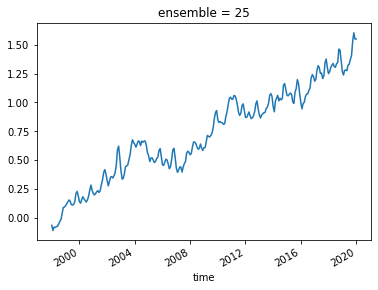

In [94]:
(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).cumsum().plot()

In [95]:
((((((canth_in_box_1998.shift(time=-1)-canth_in_box_1998).chunk(dict(time=-1)).dropna(dim='time'))))).round(4).values).mean()#.values#()

0.0058681818181818175

In [96]:
print(f'Canth Accumulation Mean: {((((((canth_in_box_1998.shift(time=-1)-canth_in_box_1998).chunk(dict(time=-1)))).mean(dim="time"))*1000).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Mean: {((((((canth_300m-canth_300m.shift(time=-1)).chunk(dict(time=-1))).mean(dim="time")))*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')

Canth Accumulation Mean: 5.868
Canth 300 Accumulation Mean: -4.994


In [97]:
print(f'Canth Accumulation Trend: {((xarray_get_trend(((-(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).chunk(dict(time=-1)))).dropna(dim="time")).sel(parameter=0)*365*1000).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_get_trend(((-(canth_300m-canth_300m.shift(time=-1)).chunk(dict(time=-1))).dropna(dim="time"))).sel(parameter=0)*365*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')

Canth Accumulation Trend: -0.113
Canth 300 Accumulation Trend: 0.254


In [98]:
((xarray_get_trend(((((itf_canth+itf_canth_gm)).sel(time=slice('2010','2020')).chunk(dict(time=-1))))).sel(parameter=0))*1000).round(3).values

array(-0.008)

In [99]:
print(f'ITF Canth FD GM Trend: {(((((((itf_canth+itf_canth_gm)).chunk(dict(time=-1))))).mean(dim="time")).round(3).values)}')

ITF Canth FD GM Trend: -0.039


In [100]:
# These are 17 year rolling trends in Terragrams.

# NEED TO DE-INTEGRATE CANTH ACCUMULATION TO CALCULATE THE TREND.

print(f'CO2 flux Trend: {((xarray_rolling_trends(co2.chunk(dict(time=-1))).mean(dim="timeperiod")*1000).round(3).values)}')

print(f'ITF Canth FD Trend: {((xarray_rolling_trends(((itf_canth.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'ITF Canth FD GM Trend: {((xarray_rolling_trends(((((itf_canth+itf_canth_gm)).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'PME Trend is {((xarray_rolling_trends(((pme_ts.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')
print(f'Canth Accumulation Trend: {((xarray_rolling_trends(((canth_in_box_1998.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_rolling_trends(((canth_300m.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')
print(f'ITF Canth 300 Trend: {((xarray_rolling_trends(((itf_canth_300.chunk(dict(time=-1))))).mean(dim="timeperiod").round(3).values))}')#{(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth 300 GM Trend: {((xarray_rolling_trends((((itf_canth_300+itf_canth_gm_300).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF SV Trend: {((xarray_rolling_trends(((itf.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(itf).mean().round(3).values}')
print(f'ITF SV 300 Trend: {((xarray_rolling_trends(((itf_300.chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(itf_300).mean().round(3).values}')

Calculating trend ensemble for default
CO2 flux Trend: 2.551
Calculating trend ensemble for default
ITF Canth FD Trend: -0.291
Calculating trend ensemble for default
ITF Canth FD GM Trend: -0.29
Calculating trend ensemble for default
PME Trend is -0.0
Calculating trend ensemble for default
Canth Accumulation Trend: 56.446
Calculating trend ensemble for default
Canth 300 Accumulation Trend: 56.589
Calculating trend ensemble for default
ITF Canth 300 Trend: -0.0
Calculating trend ensemble for default
ITF Canth 300 GM Trend: -0.195
Calculating trend ensemble for default
ITF SV Trend: 78.175
Calculating trend ensemble for default
ITF SV 300 Trend: 31.08


In [101]:
# These are 17 year rolling trends in P VALUE SIGNIFICANCE

# NEED TO DE-INTEGRATE CANTH ACCUMULATION TO CALCULATE THE TREND.

print(f'CO2 flux Trend: {((xarray_rolling_trends(co2.chunk(dict(time=-1))).mean(dim="timeperiod")).round(3).values)}')

print(f'ITF Canth FD Trend: {((xarray_rolling_trends(((itf_canth.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')
print(f'ITF Canth FD GM Trend: {((xarray_rolling_trends(((((itf_canth+itf_canth_gm)).chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')
print(f'PME Trend is {((xarray_rolling_trends(((pme_ts.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')
print(f'Canth Accumulation Trend: {((xarray_rolling_trends(((canth_in_box_1998.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')
print(f'Canth 300 Accumulation Trend: {((xarray_rolling_trends(((canth_300m.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')
print(f'ITF Canth 300 Trend: {((xarray_rolling_trends(((itf_canth_300.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod").round(3).values))}')#{(itf_canth_300).mean().round(3).values}')
print(f'ITF Canth 300 GM Trend: {((xarray_rolling_trends((((itf_canth_300+itf_canth_gm_300).chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')#{((itf_canth_300+itf_canth_gm_300)).mean().round(3).values}')
print(f'ITF SV Trend: {((xarray_rolling_trends(((itf.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')#{(itf).mean().round(3).values}')
print(f'ITF SV 300 Trend: {((xarray_rolling_trends(((itf_300.chunk(dict(time=-1)))),pval=True).mean(dim="timeperiod")).round(3).values)}')#{(itf_300).mean().round(3).values}')

Calculating trend ensemble for default
CO2 flux Trend: 0.003
Calculating trend ensemble for default
ITF Canth FD Trend: 0.614
Calculating trend ensemble for default
ITF Canth FD GM Trend: 0.614
Calculating trend ensemble for default
PME Trend is 0.491
Calculating trend ensemble for default
Canth Accumulation Trend: 0.0
Calculating trend ensemble for default
Canth 300 Accumulation Trend: 0.0
Calculating trend ensemble for default
ITF Canth 300 Trend: 0.636
Calculating trend ensemble for default
ITF Canth 300 GM Trend: 0.636
Calculating trend ensemble for default
ITF SV Trend: 0.258
Calculating trend ensemble for default
ITF SV 300 Trend: 0.39


In [102]:
((xarray_rolling_trends(((co2.chunk(dict(time=-1)))))*1000).mean(dim='timeperiod').round(3).values)

Calculating trend ensemble for default


array(2.551)

In [103]:
print(f'Canth Accumulation Trend: {((xarray_rolling_trends((((canth_in_box_1998.shift(time=-1)-canth_in_box_1998).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')# {(canth_in_box_1998.mean()/20).round(3).values}')

Calculating trend ensemble for default
Canth Accumulation Trend: -0.051


In [104]:
print(f'Canth 300 Accumulation Trend: {((xarray_rolling_trends((((canth_300m.shift(time=-1)-canth_300m).chunk(dict(time=-1))))).mean(dim="timeperiod")*1000).round(3).values)}')#{(canth_300m.mean()/20).round(3).values}')

Calculating trend ensemble for default
Canth 300 Accumulation Trend: 0.135


In [105]:
print(f'{np.round(((0.026)/0.03)*100,1)}% of Canth in equatorial Pacific is in the surface 300m')

86.7% of Canth in equatorial Pacific is in the surface 300m


In [106]:
ENSO_Table_TX=table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1'])
ENSO_Table_TX

Alltime         CP         EP    La Nina    Neutral
level_0    level_1                                                       
Subsurface 5N        5.287056   3.618791   0.830807   8.571917   3.951741
           5S       15.436039  14.878173  11.971287  16.969411  15.031934
WBC        5N        8.900815   7.928159   7.476813   9.891072   8.577826
           5S       23.436384  23.687958  23.595523  24.869054  22.188583
Surface    5N      -20.964461 -23.345256 -26.017966 -19.539042 -20.661694
           5S      -24.508417 -24.723780 -22.271519 -26.340023 -23.464888

In [107]:
ENSO_Table_TX['Neutral'].values

array([  3.95174079,  15.03193415,   8.57782629,  22.18858298,
       -20.66169426, -23.46488782])

In [108]:
(ENSO_Table_TX.subtract(ENSO_Table_TX['Neutral'].values,axis=0))#.div(ENSO_Table_TX['Neutral'].values,axis=0)*100

Alltime        CP        EP   La Nina  Neutral
level_0    level_1                                                 
Subsurface 5N       1.335315 -0.332950 -3.120934  4.620177      0.0
           5S       0.404105 -0.153761 -3.060647  1.937477      0.0
WBC        5N       0.322989 -0.649667 -1.101013  1.313246      0.0
           5S       1.247801  1.499375  1.406940  2.680471      0.0
Surface    5N      -0.302767 -2.683562 -5.356272  1.122652      0.0
           5S      -1.043529 -1.258892  1.193368 -2.875136      0.0

In [109]:
ENSO_Table_TX.subtract(ENSO_Table_TX['Neutral'].values,axis=0)


Alltime        CP        EP   La Nina  Neutral
level_0    level_1                                                 
Subsurface 5N       1.335315 -0.332950 -3.120934  4.620177      0.0
           5S       0.404105 -0.153761 -3.060647  1.937477      0.0
WBC        5N       0.322989 -0.649667 -1.101013  1.313246      0.0
           5S       1.247801  1.499375  1.406940  2.680471      0.0
Surface    5N      -0.302767 -2.683562 -5.356272  1.122652      0.0
           5S      -1.043529 -1.258892  1.193368 -2.875136      0.0

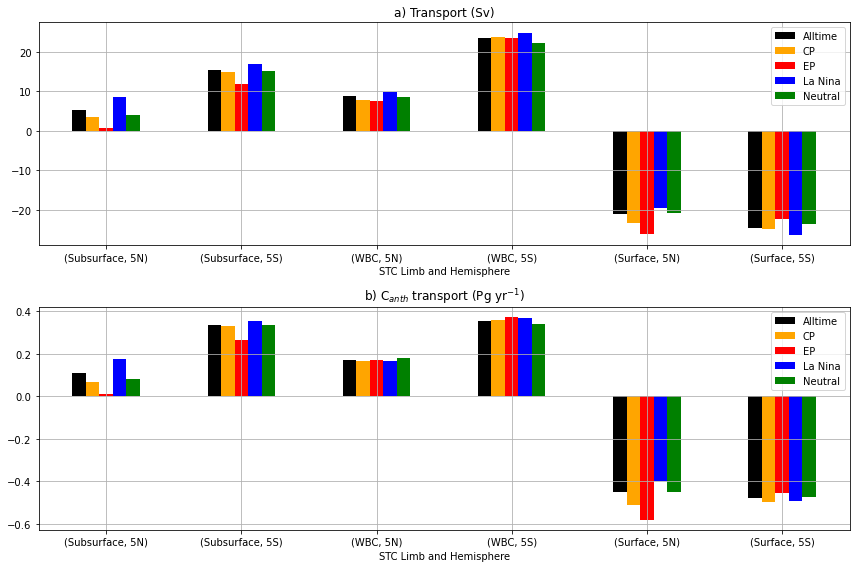

In [110]:
# CHECK ENSO CHANGES

plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['Subsurface','WBC','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('a) Transport (Sv)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.grid()

ax=plt.subplot(212)
table.loc[['Subsurface','WBC','Surface']]['AnthC transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('b) C$_{anth}$ transport (Pg yr$^{-1}$)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.tight_layout()

In [111]:
table.loc['ShallowWBC+Interior']

Meridional Transport  AnthC transport  AnthC+GM transport
5N          Alltime             12.789349         0.253667            0.276827
            CP                  10.438181         0.205363            0.228585
            EP                   8.787433         0.171065            0.191464
            La Nina             15.894078         0.306192            0.329391
            Neutral             11.622398         0.238664            0.262352
5S          Alltime             28.278266         0.578751            0.585696
            CP                  27.756235         0.576300            0.582461
            EP                  25.314773         0.530420            0.525450
            La Nina             30.769135         0.606155            0.616868
            Neutral             26.972913         0.567435            0.573857
Convergence Alltime             41.067615         0.832418            0.862523
            CP                  38.194416         0.781663            0.811045
            EP                  34.102206         0.701485            0.716913
            La Nina             46.663212         0.912347            0.946259
            Neutral             38.595311         0.806099            0.836208

## Pittman STC Table 3 Compute 
### Compute TABLE to compare ENSO phase differences as per Chapter 3

In [112]:
# CHECK ENSO CHANGES

#plt.figure(figsize=(12,8))
#ax=plt.subplot(211)
dat=table.loc[['ShallowWBC+Interior','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1=='Convergence'").set_index(['level_0','level_1'])#.plot.bar(color=['k','orange','red','blue','green'],ax=ax)

In [113]:
dat

Alltime         CP         EP    La Nina  \
level_0             level_1                                                   
ShallowWBC+Interior Convergence  41.067615  38.194416  34.102206  46.663212   
Surface             Convergence -45.472878 -48.069036 -48.289485 -45.879065   

                                   Neutral  
level_0             level_1                 
ShallowWBC+Interior Convergence  38.595311  
Surface             Convergence -44.126582

In [114]:
(dat.subtract(dat['Neutral'].values,axis=0))

Alltime        CP        EP   La Nina  \
level_0             level_1                                               
ShallowWBC+Interior Convergence  2.472304 -0.400895 -4.493105  8.067901   
Surface             Convergence -1.346296 -3.942454 -4.162903 -1.752483   

                                 Neutral  
level_0             level_1               
ShallowWBC+Interior Convergence      0.0  
Surface             Convergence      0.0

In [115]:
((dat['CP']-dat['Neutral'])/dat['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence   -1.038714
Surface              Convergence    8.934421
dtype: float64

In [116]:
((dat['EP']-dat['Neutral'])/dat['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence   -11.641583
Surface              Convergence     9.434003
dtype: float64

In [117]:
((dat['La Nina']-dat['Neutral'])/dat['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence    20.903838
Surface              Convergence     3.971491
dtype: float64

In [118]:
(dat.loc['ShallowWBC+Interior']+dat.loc['Surface']).sum(axis=0)

Alltime    -4.405263
CP         -9.874620
EP        -14.187279
La Nina     0.784147
Neutral    -5.531271
dtype: float64

In [119]:
dat1=table.loc[['ShallowWBC+Interior','Surface']]['AnthC+GM transport'].unstack().reset_index().query("level_1=='Convergence'").set_index(['level_0','level_1'])#.plot.bar(color=['k','orange','red','blue','green'],ax=ax)
dat1

Alltime        CP        EP   La Nina  \
level_0             level_1                                               
ShallowWBC+Interior Convergence  0.862523  0.811045  0.716913  0.946259   
Surface             Convergence -0.965498 -1.045646 -1.056419 -0.932889   

                                  Neutral  
level_0             level_1                
ShallowWBC+Interior Convergence  0.836208  
Surface             Convergence -0.959979

In [120]:
(dat1.subtract(dat1['Neutral'].values,axis=0))#.div(ENSO_Table_TX['Neutral'].values,axis=0)*100

Alltime        CP        EP  La Nina  \
level_0             level_1                                              
ShallowWBC+Interior Convergence  0.026315 -0.025163 -0.119295  0.11005   
Surface             Convergence -0.005518 -0.085667 -0.096440  0.02709   

                                 Neutral  
level_0             level_1               
ShallowWBC+Interior Convergence      0.0  
Surface             Convergence      0.0

In [121]:
((dat1['CP']-dat1['Neutral'])/dat1['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence   -3.009164
Surface              Convergence    8.923836
dtype: float64

In [122]:
((dat1['EP']-dat1['Neutral'])/dat1['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence   -14.266155
Surface              Convergence    10.046039
dtype: float64

In [123]:
((dat1['La Nina']-dat1['Neutral'])/dat1['Neutral'])*100

level_0              level_1    
ShallowWBC+Interior  Convergence    13.160656
Surface              Convergence    -2.821935
dtype: float64

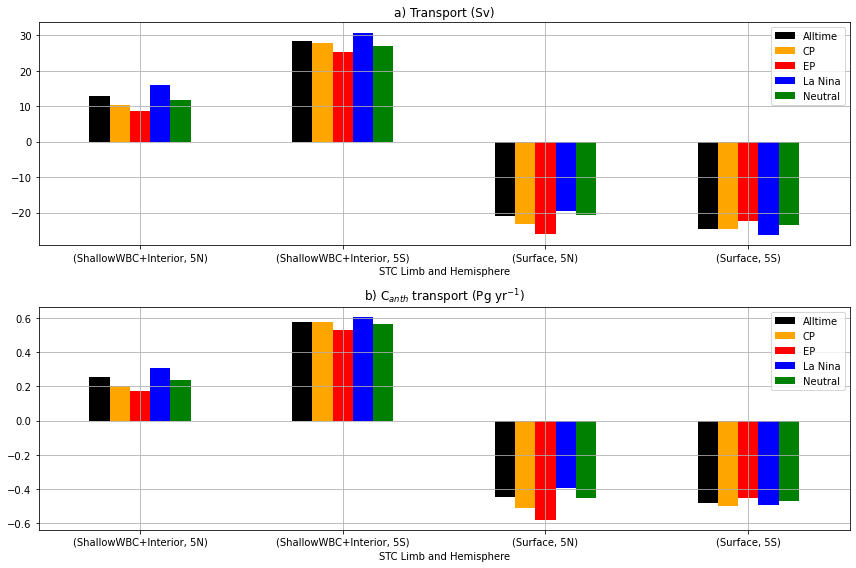

In [125]:
# CHECK ENSO CHANGES

plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['ShallowWBC+Interior','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('a) Transport (Sv)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.grid()

ax=plt.subplot(212)
table.loc[['ShallowWBC+Interior','Surface']]['AnthC transport'].unstack().reset_index().query("level_1!='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('b) C$_{anth}$ transport (Pg yr$^{-1}$)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.tight_layout()

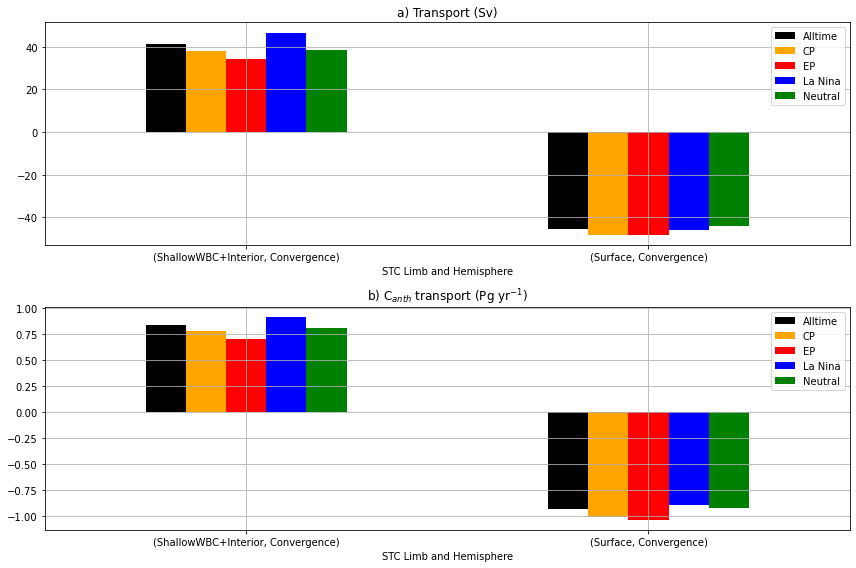

In [126]:
# CHECK ENSO CHANGES

plt.figure(figsize=(12,8))
ax=plt.subplot(211)
table.loc[['ShallowWBC+Interior','Surface']]['Meridional Transport'].unstack().reset_index().query("level_1=='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.title('a) Transport (Sv)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.grid()

ax=plt.subplot(212)
table.loc[['ShallowWBC+Interior','Surface']]['AnthC transport'].unstack().reset_index().query("level_1=='Convergence'").set_index(['level_0','level_1']).plot.bar(color=['k','orange','red','blue','green'],ax=ax)
plt.grid()
plt.title('b) C$_{anth}$ transport (Pg yr$^{-1}$)')
plt.xticks(rotation=360)
plt.xlabel('STC Limb and Hemisphere')
plt.tight_layout()

In [127]:
vtx=phys_eqpac.v.sel(ensemble=25,lat_x=[-5,5],method='nearest').sel(time=slice('1998-01-01','2020-01-01'))
vtx_load=vtx.load()
vtx

<xarray.DataArray 'v' (time: 265, st_ocean: 50, lat_x: 2, lon_x: 171)>
array([[[[        nan,  0.1222627 ,         nan, ...,         nan,
                  nan,         nan],
         [ 0.04672686,  0.03210798,  0.04577971, ...,         nan,
                  nan,         nan]],

        [[        nan,  0.11589941,         nan, ...,         nan,
                  nan,         nan],
         [ 0.06713666,  0.05348596,  0.06715767, ...,         nan,
                  nan,         nan]],

        [[        nan,  0.07929654,         nan, ...,         nan,
                  nan,         nan],
         [ 0.07666802,  0.06277655,  0.07621783, ...,         nan,
                  nan,         nan]],

        ...,

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
...
                  nan,         nan],
         [-0.03562569,  0.02126523,  0.06922018, ...,         nan,
                  nan,         nan]],

        ...,

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time      (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2020-01-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat_x     (lat_x) float64 -5.0 5.0
Attributes:
    cell_methods:   time: mean
    long_name:      j-current
    standard_name:  sea_water_y_velocity
    units:          m/sec
    valid_range:    [-10.0, 10.0]

In [129]:
lon_face_length_m=gr_slice.ds_00_02_T
lat_face_length_m=gr_slice.ds_20_22_T
st_ocean_holder

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([5.000000e+00, 1.500000e+01, 2.500000e+01, 3.500000e+01, 4.500000e+01,
       5.500000e+01, 6.500000e+01, 7.500000e+01, 8.500000e+01, 9.500000e+01,
       1.050000e+02, 1.150000e+02, 1.250000e+02, 1.350000e+02, 1.450000e+02,
       1.550000e+02, 1.650000e+02, 1.750000e+02, 1.850000e+02, 1.950000e+02,
       2.050000e+02, 2.168468e+02, 2.413490e+02, 2.807807e+02, 3.432505e+02,
       4.273156e+02, 5.367156e+02, 6.654141e+02, 8.127816e+02, 9.690651e+02,
       1.130935e+03, 1.289605e+03, 1.455770e+03, 1.622926e+03, 1.801558e+03,
       1.984855e+03, 2.182905e+03, 2.388417e+03, 2.610935e+03, 2.842564e+03,
       3.092205e+03, 3.351295e+03, 3.628058e+03, 3.913264e+03, 4.214495e+03,
       4.521918e+03, 4.842566e+03, 5.166130e+03, 5.499245e+03, 5.831294e+03])
Coordinates:
    ensemble    int32 25
  * st_ocean    (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    depth_diff  (st_ocean) float64 5.0 10.0 10.0 10.0 ... 323.6 333.1 332.0
Attributes:
    cartesian_axis:  Z
    edges:           st_edges_ocean
    long_name:       tcell zstar depth
    positive:        down
    units:           meters

In [130]:
vtx1=phys_eqpac.v.sel(ensemble=25,time='2020-01-01',method='nearest').sel(lat_x=slice(-40,40))#time=slice('1998-01-01','2020-01-01')
vtx1_load=vtx1.load()

## Pittman STC Figure 2

1
2
3
4
5
6
7
8
9
10


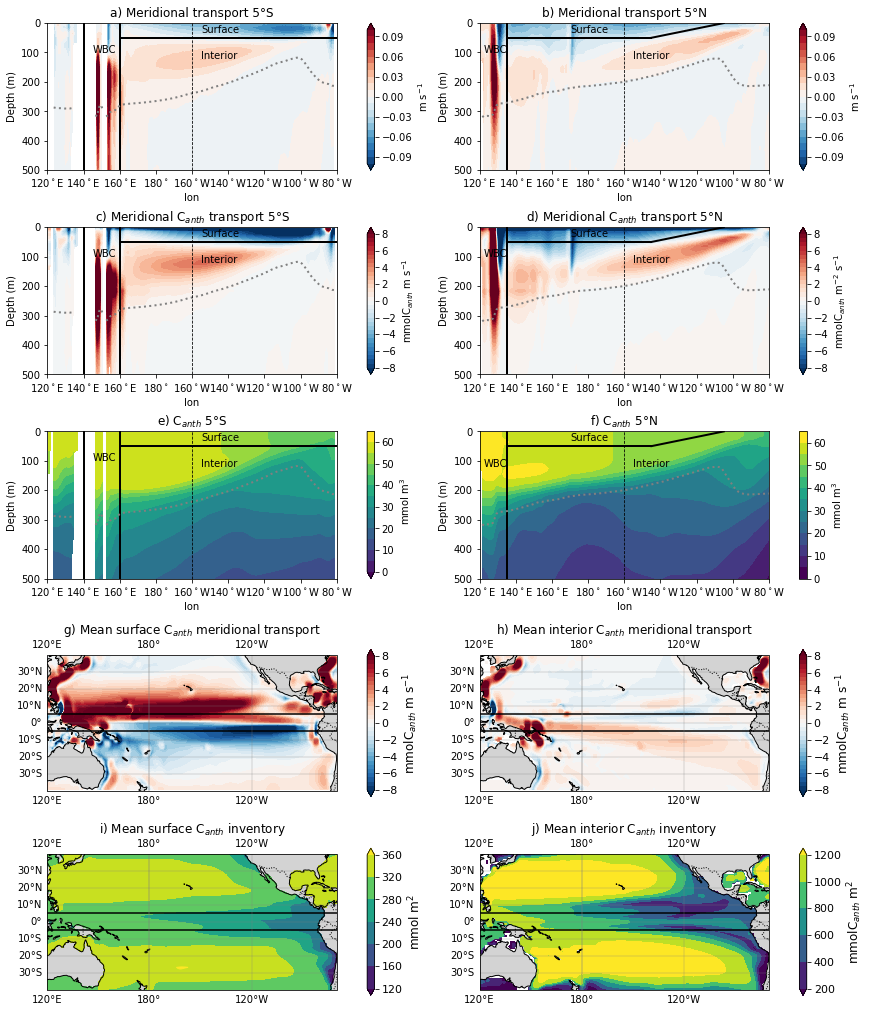

In [186]:

positions = (120,140, 160, 180,200,220,240,260,280)
labels = ("120$^\circ$E", "140$^\circ$E", "160$^\circ$E", "180$^\circ$",'160$^\circ$W','140$^\circ$W','120$^\circ$W','100$^\circ$W',"80$^\circ$W")

plt.figure(figsize=(12,14),constrained_layout=True)
  
# Sometimes need to run this tice?
plt.subplot(5,2,1)
(vtx.sel(lat_x=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#

plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.title('a) Meridional transport 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)


plt.text(205,32,'Surface')
plt.text(145,100,'WBC')
plt.text(205,120,'Interior')



plt.ylim([500,0])
#plt.ylim([-500,0])
plt.ylabel('Depth (m)')
print('1')

plt.subplot(5,2,2)
#(-tv.sel(lat=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-1,1.1,0.5),cmap='RdBu_r', cbar_kwargs={'label': 'm$^{2}$ s$^{-1}$'})#sel(time='1998-01-01').plot()
(-vtx.sel(lat_x=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.1,0.11,0.01),cmap='RdBu_r',cbar_kwargs={'label': 'm s$^{-1}$'})#

plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[600,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.xlim([120,280])
plt.ylabel('Depth (m)')
plt.xticks(positions, labels)




plt.text(170,32,'Surface')
plt.text(122,100,'WBC')
plt.text(205,120,'Interior')




#plt.ylim([-500,0])
plt.ylim([500,0])
plt.title('b) Meridional transport 5°N')
print('2')
                
plt.subplot(5,2,3)

#(tv_canth.sel(lat=-5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.002,0.0025,0.0005),cmap='RdBu_r',cbar_kwargs={'label': 'mmol cell s$^{-1}$'})#sel(time='1998-01-01').plot()
((((tv_canth+tv_canth_gm)/12/365/24/60/60*1e18)).sel(lat=-5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=-5,method='nearest')/st_ocean_holder.depth_diff).plot.contourf(levels=np.arange(-8,8.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmolC$_{anth}$ m s$^{-1}$'})#sel(time='1998-01-01').plot()

plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.title('c) Meridional C$_{anth}$ transport 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)




plt.text(205,32,'Surface')
plt.text(145,100,'WBC')
plt.text(205,120,'Interior')



#plt.ylim([-500,0])
plt.ylim([500,0])
plt.ylabel('Depth (m)')
print('3')
plt.subplot(5,2,4)

#(-tv_canth.sel(lat=5,method='nearest').mean(dim='time')).plot.contourf(levels=np.arange(-0.002,0.0025,0.0005),cmap='RdBu_r',cbar_kwargs={'label': 'mmol cell s$^{-1}$'})#sel(time='1998-01-01').plot()
(((-(tv_canth+tv_canth_gm)/12/365/24/60/60*1e18)).sel(lat=5,method='nearest').mean(dim='time')/lon_face_length_m.sel(lat=5,method='nearest')/st_ocean_holder.depth_diff).plot.contourf(levels=np.arange(-8,8.5,0.5),cmap='RdBu_r',cbar_kwargs={'label': 'mmolC$_{anth}$ m$^{-2}$ s$^{-1}$'})#sel(time='1998-01-01').plot()

plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[400,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.title('d) Meridional C$_{anth}$ transport 5°N')
plt.xlim([120,280])
plt.xticks(positions, labels)



plt.text(170,32,'Surface')
plt.text(122,100,'WBC')
plt.text(205,120,'Interior')




#plt.ylim([-500,0])
plt.ylim([500,0])
plt.ylabel('Depth (m)')

print('4')
plt.subplot(5,2,5)
(raw_anth_c.sel(lat=-5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis',cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,70,5)))#10000,1000)))


plt.plot([160,280],[50,50],c='k',linewidth=2)
plt.plot([140,140],[600,0],c='k',linewidth=2)
plt.plot([160,160],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=-5.1,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.title('e) C$_{anth}$ 5°S')
plt.xlim([120,280])
plt.xticks(positions, labels)



plt.text(205,32,'Surface')
plt.text(145,100,'WBC')
plt.text(205,120,'Interior')


plt.ylim([500,0])
plt.ylabel('Depth (m)')
print('5')
plt.subplot(5,2,6)
(raw_anth_c.sel(lat=5,method='nearest').mean(dim='time').plot.contourf(cmap='viridis', cbar_kwargs={'label': 'mmol m$^{3}$'},levels=np.arange(0,70,5)))##,levels=np.arange(0,10000,1000)))#np.arange(0,2200,200)))



plt.plot([135,215],[50,50],c='k',linewidth=2)
plt.plot([215,255],[50,0],c='k',linewidth=2)
plt.plot([115,115],[400,0],c='k',linewidth=2)
plt.plot([135,135],[1000,0],c='k',linewidth=2)
cafe_potential_density_rev.chunk('auto').sel(lat=5,method='nearest').mean(dim='time').plot.contour(levels=[1026.3],colors='gray',linestyles=':',linewidths=2)
plt.axvline(200,c='k',linewidth=0.8,linestyle='--')
plt.xlim([120,280])
plt.xticks(positions, labels)

plt.ylabel('Depth (m)')
plt.ylim([500,0])
plt.title('f) C$_{anth}$ 5°N')




plt.text(170,32,'Surface')
plt.text(122,120,'WBC')
plt.text(205,120,'Interior')



print('6')

dat1=(((tv_canth_400+tv_canth_gm_400)/12/365/24/60/60*1e18).where((tv_canth+tv_canth_gm).st_ocean<50)/lon_face_length_m.interp(lat=tv_canth_400.lat)/st_ocean_holder.depth_diff).mean(dim='st_ocean').mean(dim='time').chunk('auto')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1,axn=7,sb1=5,sb2=2,title='g) Mean surface C$_{anth}$ meridional transport',lon='lon',lat='lat',units='mmolC$_{anth}$ m s$^{-1}$',levs=np.arange(-8,8.5,0.5),extend='both')
print('7')
# Subsurface
dat2=(((tv_canth_400+tv_canth_gm_400)/12/365/24/60/60*1e18).where((tv_canth_400+tv_canth_gm_400).st_ocean>50)/lon_face_length_m.interp(lat=tv_canth_400.lat)/st_ocean_holder.depth_diff).where(cafe_potential_density_rev.chunk('auto').interp(lat=tv_canth_400.lat)<=1026.3).chunk('auto').mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Mean interior C$_{anth}$ meridional transport',lon='lon',lat='lat',units='mmolC$_{anth}$ m s$^{-1}$',levs=np.arange(-8,8.5,0.5),extend='both')
#dat2=((((tv_canth_400+tv_canth_gm_400).load()/12/24/60/60/365)*1e18)/lon_face_length_m/lat_face_length_m).where((tv_canth_400+tv_canth_gm_400).st_ocean>50).where(cafe_potential_density_rev.chunk('auto').interp(lat=tv_canth_400.lat)<=1026.3).chunk('auto').mean(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2,axn=8,sb1=5,sb2=2,title='h) Interior C$_{anth}$ meridional transport (>50 m and <1026.3)',lon='lon',lat='lat',units='mmol m s$^{-1}$',extend='both')

print('8')

#dat1=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(0,-50)).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Surface C$_{anth}$ inventory (<50m)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,4.1,0.1))#np.arange(0,1998,100))#np.arange(0,10000,1000))

# Subsurface
#dat2=(adic_plot*st_ocean_holder1.depth_diff/1000).sel(st_ocean=slice(-50,-450)).where(cafe_potential_density.chunk('auto').interp({'lat':adic_plot.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
#plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Subsurface C$_{anth}$ inventory (>50m and <1026.3)',lon='lon',lat='lat',units='mol m$^{2}$',extend='both',cmap='viridis',levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,1998,100))#) #np.arange(-30,33,3)

dat1=(raw_anth_c_large).sel(st_ocean=slice(0,50)).sum(dim='st_ocean').mean(dim='time').chunk('auto')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat1.where(dat1!=0),axn=9,sb1=5,sb2=2,title='i) Mean surface C$_{anth}$ inventory',lon='lon',lat='lat',units='mmol m$^{2}$',extend='both',cmap='viridis')#,levs=np.arange(0,4.1,0.1))#np.arange(0,1998,100))#np.arange(0,10000,1000)) #,levs=np.arange(20,75,5)

print('9')
dat2=(raw_anth_c_large).sel(st_ocean=slice(50,450)).where(cafe_potential_density_rev.chunk('auto').interp({'lat':raw_anth_c_large.lat})<=1026.3).sum(dim='st_ocean').mean(dim='time')#.plot(vmin=-3,vmax=3,cmap='RdBu_r')
plot_cartopy_row(dat2.where(dat2!=0),axn=10,sb1=5,sb2=2,title='j) Mean interior C$_{anth}$ inventory',lon='lon',lat='lat',units='mmolC$_{anth}$ m$^{2}$',extend='both',cmap='viridis')#,levs=np.arange(0,21,1))#,levs=np.arange(0,80,10))#np.arange(0,1998,100))#) #np.arange(-30,33,3)
print('10')


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#plt.tight_layout()
plt.show()

In [176]:
#tv, tv_gm, tv_canth, tv_canth_gm, same as us. 

ymertrans_wbcS=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_surfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_subsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_WBCsubsurfaceS=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()

ymertrans_wbcN=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_surfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_subsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_WBCsubsurfaceN=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()


ymertrans_wbcS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_surfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_subsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_WBCsubsurfaceS_seasonal=tv.sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()

ymertrans_wbcN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_surfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_subsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
ymertrans_WBCsubsurfaceN_seasonal=-tv.sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()


ymertrans_wbc=ymertrans_wbcN+ymertrans_wbcS
ymertrans_surface=ymertrans_surfaceN+ymertrans_surfaceS
ymertrans_subsurface=ymertrans_subsurfaceN+ymertrans_subsurfaceS

ymertrans_S=tv.sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()
ymertrans_N=-tv.sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()

#(ymertrans_wbc-ymertrans_wbc.mean()).plot(ax=ax,c='r')
#(ymertrans_surface-ymertrans_surface.mean()).plot(ax=ax,c='g')
#(ymertrans_subsurface-ymertrans_subsurface.mean()).plot(ax=ax,c='b')
interior=ymertrans_wbcS+ymertrans_wbcN+ymertrans_subsurfaceN+ymertrans_subsurfaceS
surface=ymertrans_surfaceN+ymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN


#anth_dic_area_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')

#anth_dic_area_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_area_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/raw_canth_area_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')

#((x*60*60*24*365*12)/1e18)
canth_u=tu_canth.sel(lat=120,method='nearest')#(((anth_dic_area_u_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx=tv_canth#(((anth_dic_area_v_tx)*60*60*24*365*12)/1e18)/1e6
anth_dic_v_tx_gm=tv_canth_gm#(((anth_dic_area_v_tx_gm)*60*60*24*365*12)/1e18)/1e6


anthymertrans_wbcS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_surfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_subsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_WBCsubsurfaceS=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()

anthymertrans_wbcN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_surfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_subsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_WBCsubsurfaceN=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()


anthymertrans_S=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()
anthymertrans_N=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()


anth_interior=anthymertrans_wbcS+anthymertrans_wbcN+anthymertrans_subsurfaceN+anthymertrans_subsurfaceS
anth_surface=anthymertrans_surfaceN+anthymertrans_surfaceS#mertrans_surface+ymertrans_surfaceN



anthymertrans_wbcS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.shallow_south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_surfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_subsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_WBCsubsurfaceS_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.south_shallowwbc_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()


anthymertrans_wbcN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.shallow_north_wbc.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_surfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_surface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_subsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.plot()#.sel(time='1998-01-01').plot()
anthymertrans_WBCsubsurfaceN_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.north_shallowwbc_subsurface.sel(lat=5,method='nearest')==1).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()


anthymertrans_S_seasonal=(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=-5,method='nearest').where(region_mask.above_isopycnal.sel(lat=-5,method='nearest')==1).sel(lon=slice(140,300)).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()
anthymertrans_N_seasonal=-(anth_dic_v_tx+anth_dic_v_tx_gm).sel(lat=5,method='nearest').where(region_mask.above_isopycnal.sel(lat=5,method='nearest')==1).sel(lon=slice(120,300)).sum(['st_ocean','lon'])#.rolling(time=12,center=True).mean()

anth_interior_seasonal=anthymertrans_wbcS_seasonal+anthymertrans_wbcN_seasonal+anthymertrans_subsurfaceN_seasonal+anthymertrans_subsurfaceS_seasonal
anth_surface_seasonal=anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal#mertrans_surface+ymertrans_surfaceN


In [ ]:
ax=plt.subplot(111)

(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceN-ymertrans_surfaceN.mean()).time,(ymertrans_surface-ymertrans_surface.mean()).values,0,color='g',alpha=0.5)

plt.show()
    
#ax.plot(X, Y, color='blue', alpha=1.00)
#ax.fill_between(X, Y, 0, color='blue', alpha=.1)    

In [137]:
surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18


surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18



#upwelling1=((anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=(anth_surface_seasonal)#*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=((anthymertrans_wbcS+anthymertrans_wbcN))#*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN))#*60*60*24*365*12)/1e18
interior_in=((anthymertrans_subsurfaceS+anthymertrans_subsurfaceN))#*60*60*24*365*12)/1e18#.sum(['lat','lon'])
euc_in=itf_canth#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12,center=True).mean()

## Pittman STC Figure 5 Alternate

/local/v45/np1383/tmp/ipykernel_1831767/2598070741.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe8e5a1e670> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/2598070741.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe6baae8970> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/2598070741.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe6ba86ab20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/2598070741.py:63: UserWarning: The h

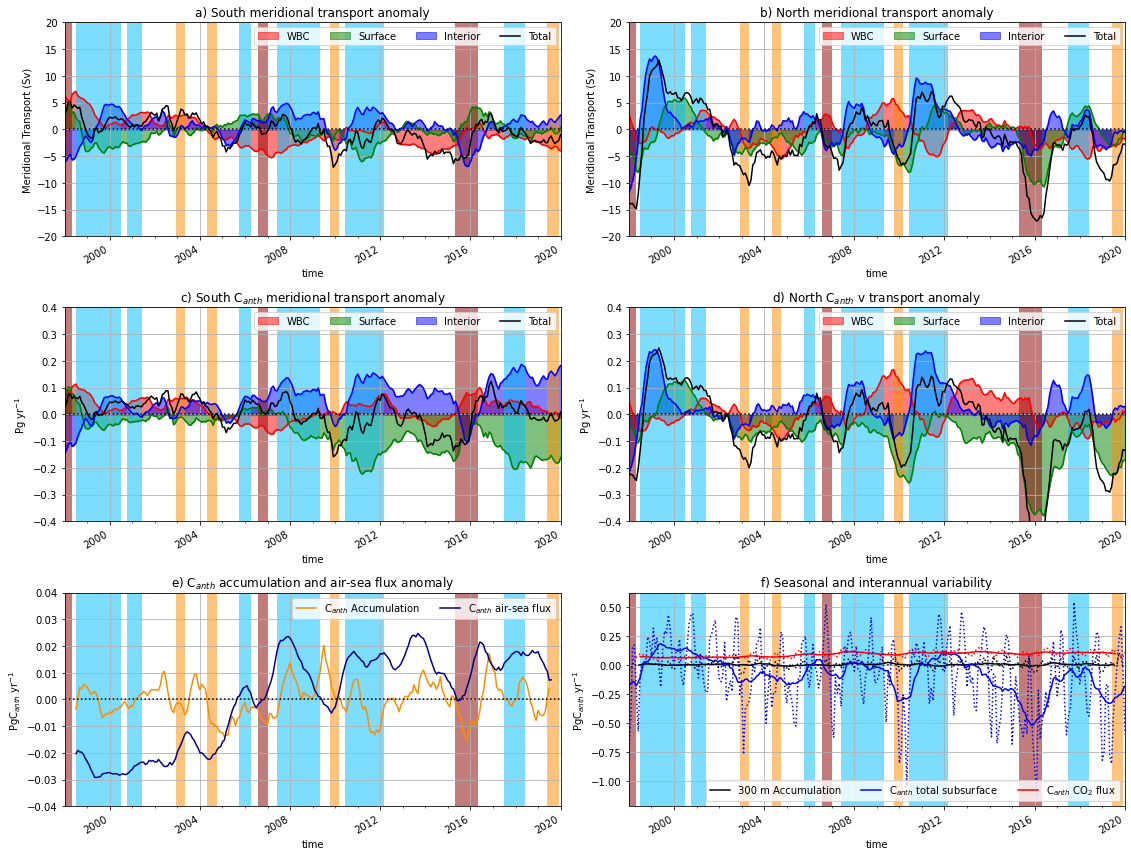

In [138]:
# Replicate Zeller

# NEED TO LOAD MORE DATA IN TO MAKE THIS HAPPEN? 1980-2020
#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(16,12))

gs=fig.add_gridspec(3,4)

#ax=plt.subplot(421)#
#ax=fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])


ax=plt.subplot(321)
#ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
#ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
#ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()

(ymertrans_wbcS-ymertrans_wbcS.mean()).plot(ax=ax,c='r')
ax.fill_between((ymertrans_wbcS-ymertrans_wbcS.mean()).time,(ymertrans_wbcS-ymertrans_wbcS.mean()).values,0,color='red',alpha=0.5)
(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceS-ymertrans_surfaceS.mean()).time,(ymertrans_surfaceS-ymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)
(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).plot(ax=ax,c='b')
ax.fill_between((ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).time,(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).values,0,color='b',alpha=0.5)
#(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).plot(ax=ax,c='r',linestyle=':')

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='k')
#(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
#(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
#((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')


ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) South meridional transport anomaly')
ax.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5)
add_enso_colours(ax)
ax.set_ylabel('Meridional Transport (Sv)')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')
plt.grid()



ax=plt.subplot(322)
#26.34*1.025
#26.34*1.025

(ymertrans_wbcN-ymertrans_wbcN.mean()).plot(ax=ax,c='r')
ax.fill_between((ymertrans_wbcN-ymertrans_wbcN.mean()).time,(ymertrans_wbcN-ymertrans_wbcN.mean()).values,0,color='r',alpha=0.5)

(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceN-ymertrans_surfaceN.mean()).time,(ymertrans_surfaceN-ymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)

(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
ax.fill_between((ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).time,(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).values,0,color='b',alpha=0.5)

#(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r',linestyle=':')
((ymertrans_N-ymertrans_N.mean())).plot(ax=ax,c='k')

ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5)
plt.title('b) North meridional transport anomaly')
add_enso_colours(ax)
ax.set_ylim([-20,20])
plt.axhline(0,c='k',linestyle=':')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylabel('Meridional Transport (Sv)')
plt.grid()


#ax=plt.subplot(425)#
#ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])

ax=plt.subplot(323)
#26.34*1.025
#26.34*1.025


(((anthymertrans_wbcS-anthymertrans_wbcS.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_wbcS-anthymertrans_wbcS.mean()).time,(anthymertrans_wbcS-anthymertrans_wbcS.mean()).values,0,color='r',alpha=0.5)

(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceS-ymertrans_surfaceN.mean()).time,(anthymertrans_surfaceS-anthymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)

(((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()))).plot(ax=ax,c='b')
ax.fill_between((anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()).time,(anthymertrans_subsurfaceS-anthymertrans_subsurfaceS.mean()).values,0,color='b',alpha=0.5)

#(((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()))).plot(ax=ax,c='r',linestyle=':')
(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='k')


#(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g')
#(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='g',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
#((((anthymertrans_wbcS+anthymertrans_subsurfaceS)-(anthymertrans_wbcS+anthymertrans_subsurfaceS).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')


ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior', 'Total'],ncol=5)
plt.title('c) South C$_{anth}$ meridional transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')

add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-0.4,0.4])
plt.grid()


ax=plt.subplot(324)
#26.34*1.025
#26.34*1.025

(((anthymertrans_wbcN-anthymertrans_wbcN.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_wbcN-anthymertrans_wbcN.mean()).time,(anthymertrans_wbcN-anthymertrans_wbcN.mean()).values,0,color='r',alpha=0.5)

(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).time,(anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)

(((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()))).plot(ax=ax,c='b')
ax.fill_between((anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()).time,(anthymertrans_subsurfaceN-anthymertrans_subsurfaceN.mean()).values,0,color='b',alpha=0.5)

#((((anthymertrans_wbcN+anthymertrans_subsurfaceN)-(anthymertrans_wbcN+anthymertrans_subsurfaceN).mean())*60*60*24*365*12)/1e18).plot(ax=ax,c='r',linestyle=':')
#(((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()))).plot(ax=ax,c='r',linestyle=':')
((((anthymertrans_N-anthymertrans_N.mean())))).plot(ax=ax,c='k')


add_enso_colours(ax)

ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC','_nolegend_','Surface','_nolegend_','Interior','Total'],ncol=5) #, 'Interior+WBC'
plt.title('d) North C$_{anth}$ v transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')
#ax.set_xlabel('Meridional C$_{anth}$ Transport (Pg yr$^{-1}$)')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))

plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.4,0.4])
plt.grid()






#ax=plt.subplot(425)#
#ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
#(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='gray')
#((((anthymertrans_N-anthymertrans_N.mean())))).plot(ax=ax,c='k')
ax=plt.subplot(325)



canth_acc_300=((canth_300m.shift(time=-1))-canth_300m) #_1980
(canth_acc_300-canth_acc_300.mean()).rolling(time=12,center=True).mean().plot(c='darkorange')
(co2-co2.mean()).rolling(time=12,center=True).mean().plot(c='darkblue') #_80

ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
ax.set_title('e) C$_{anth}$ accumulation and air-sea flux anomaly')
ax.legend(['C$_{anth}$ Accumulation','C$_{anth}$ air-sea flux'],ncol=2)
add_enso_colours(ax)

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-0.04,0.04])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.grid()


ax=plt.subplot(326)
((canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).rolling(time=12, center=True)).mean().plot(c='k')
#((canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).rolling(time=12,center=True)).mean().plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
(((surface_out+wbcsubsurface_in).rolling(time=12, center=True)).mean().sel(time=slice('1998','2020'))).plot(c='blue')
(((co2.rolling(time=12,center=True)).mean()).sel(time=slice('1998','2020'))).plot(c='r')
#((itf_canth.rolling(time=12, center=True)).mean()).plot(c='m')

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
(canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).plot(c='k',linestyle=':',label='__nolegend__')
#(canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).plot(c='red',linestyle=':',label='__nolegend__')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020'))).plot(c='blue',linestyle=':',label='__nolegend__')
((co2).sel(time=slice('1998','2020'))).plot(c='r',linestyle=':',label='__nolegend__')
#(itf_canth).plot(c='m',linestyle=':',label='__nolegend__')


ax.xaxis.set_minor_locator(AutoMinorLocator(4))
add_enso_colours(ax)
#.rolling(time=12,center=True)).mean()
plt.title('f) Seasonal and interannual variability')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
plt.legend(['300 m Accumulation', 'C$_{anth}$ total subsurface' ,'C$_{anth}$ CO$_{2}$ flux'],ncol=3)# 'surf+subsurf+wbc+co2'
plt.grid()

plt.tight_layout()

## Pittman STC Figure 5

/local/v45/np1383/tmp/ipykernel_1831767/3431565220.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe6ba7a0910> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/3431565220.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe8f6bf7520> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/3431565220.py:65: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fe72c863910> has a label of '_nolegend_' which cannot be automatically added to the legend.
  plt.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total'],ncol=5)
/local/v45/np1383/tmp/ipykernel_1831767/3431565220.py:65: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7

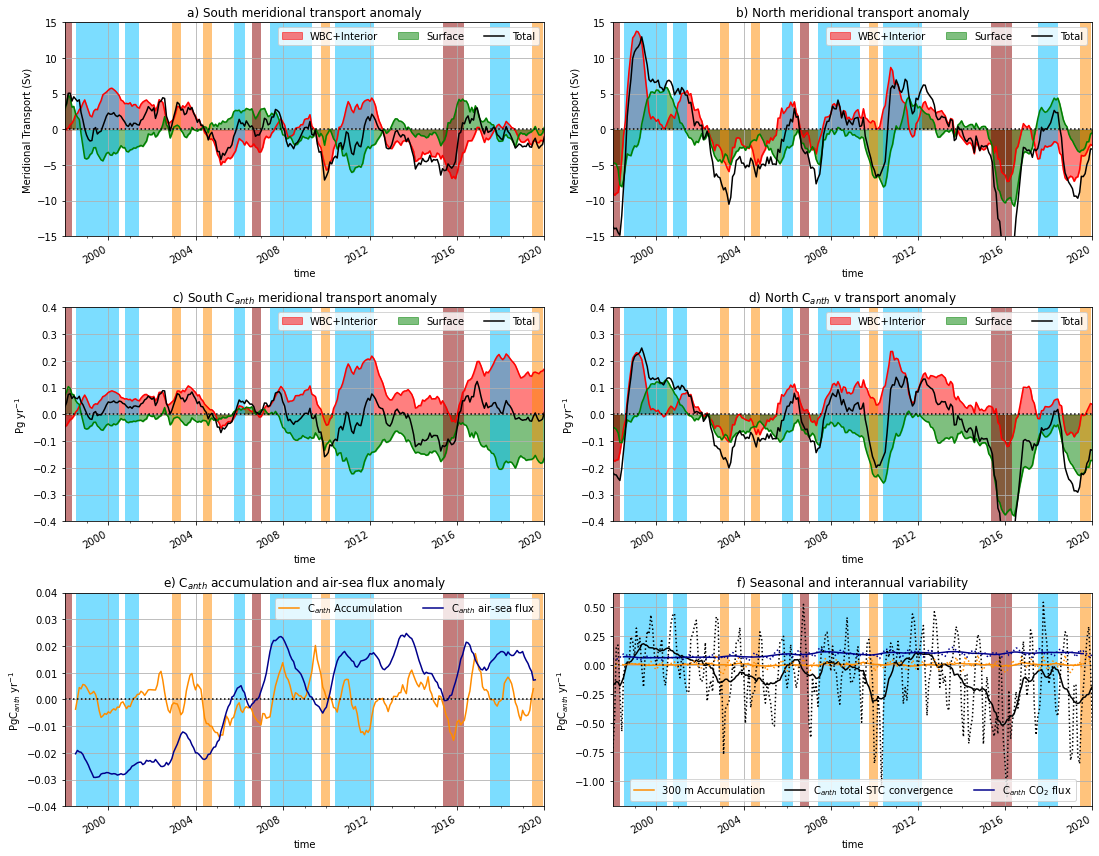

In [139]:
# Replicate Zeller, WBC+INterior as one

# NEED TO LOAD MORE DATA IN TO MAKE THIS HAPPEN? 1980-2020
#26.34*1.025
#26.34*1.025
fig=plt.figure(figsize=(16,12))


#gs=fig.add_gridspec(3,4)

#ax=plt.subplot(421)#
#ax=fig.add_subplot(gs[0,1:3]) #plt.subplot(3,4,[2,3])


ax=plt.subplot(321)
#ymertrans_wbc=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_wbc.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
#ymertrans_surface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_surface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()
#ymertrans_subsurface=cafe_y_tx.sel(lat_x=-5,method='nearest').where(region_mask.south_subsurface.sel(lat=-5,method='nearest')==1).sum(['st_ocean','lon']).rolling(time=12,center=True).mean()#.plot()#.sel(time='1998-01-01').plot()

(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).plot(ax=ax,c='r')
ax.fill_between(((ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean())).time,(ymertrans_WBCsubsurfaceS-ymertrans_WBCsubsurfaceS.mean()).values,0,color='r',alpha=0.5)

(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceS-ymertrans_surfaceS.mean()).time,(ymertrans_surfaceS-ymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)
#(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).plot(ax=ax,c='b')
#ax.fill_between((ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).time,(ymertrans_subsurfaceS-ymertrans_subsurfaceS.mean()).values,0,color='b',alpha=0.5)

#.plot(ax=ax,c='r',linestyle=':')

(ymertrans_S-ymertrans_S.mean()).plot(ax=ax,c='k')
#(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
#(ymertrans_surfaceS-ymertrans_surfaceS.mean()).plot(ax=ax,c='g',linestyle=':')
#((ymertrans_wbcN+ymertrans_subsurfaceN)-(ymertrans_wbcN+ymertrans_subsurfaceN).mean()).plot(ax=ax,c='r')


ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
ax.set_title('a) South meridional transport anomaly')
ax.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total convergence'],ncol=5)
add_enso_colours(ax)
ax.set_ylabel('Meridional Transport (Sv)')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-15,15])
plt.axhline(0,c='k',linestyle=':')
plt.grid()



ax=plt.subplot(322)
#26.34*1.025
#26.34*1.025

(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r')
ax.fill_between(((ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean())).time,((ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean())).values,0,color='r',alpha=0.5)

(ymertrans_surfaceN-ymertrans_surfaceN.mean()).plot(ax=ax,c='g')
ax.fill_between((ymertrans_surfaceN-ymertrans_surfaceN.mean()).time,(ymertrans_surfaceN-ymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)

#(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).plot(ax=ax,c='b')
#ax.fill_between((ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).time,(ymertrans_subsurfaceN-ymertrans_subsurfaceN.mean()).values,0,color='b',alpha=0.5)

#(ymertrans_WBCsubsurfaceN-ymertrans_WBCsubsurfaceN.mean()).plot(ax=ax,c='r',linestyle=':')
((ymertrans_N-ymertrans_N.mean())).plot(ax=ax,c='k')

ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total convergence'],ncol=5)
plt.title('b) North meridional transport anomaly')
add_enso_colours(ax)
ax.set_ylim([-15,15])
plt.axhline(0,c='k',linestyle=':')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylabel('Meridional Transport (Sv)')
plt.grid()


#ax=plt.subplot(425)#
#ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])

ax=plt.subplot(323)
#26.34*1.025
#26.34*1.025


(((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()).time,(anthymertrans_WBCsubsurfaceS-anthymertrans_WBCsubsurfaceS.mean()).values,0,color='r',alpha=0.5)
(((anthymertrans_surfaceS-anthymertrans_surfaceS.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceS-ymertrans_surfaceN.mean()).time,(anthymertrans_surfaceS-anthymertrans_surfaceS.mean()).values,0,color='g',alpha=0.5)
(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='k')

plt.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface', 'Total convergence'],ncol=5)


ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.title('c) South C$_{anth}$ meridional transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')

add_enso_colours(ax)
plt.axhline(0,c='k',linestyle=':')

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-0.4,0.4])
plt.grid()


ax=plt.subplot(324)
#26.34*1.025
#26.34*1.025

(((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()))).plot(ax=ax,c='r')
ax.fill_between((anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()).time,(anthymertrans_WBCsubsurfaceN-anthymertrans_WBCsubsurfaceN.mean()).values,0,color='r',alpha=0.5)
(((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()))).plot(ax=ax,c='g')
ax.fill_between((anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).time,(anthymertrans_surfaceN-anthymertrans_surfaceN.mean()).values,0,color='g',alpha=0.5)
((((anthymertrans_N-anthymertrans_N.mean())))).plot(ax=ax,c='k')
plt.legend(['_nolegend_','WBC+Interior','_nolegend_','Surface','Total convergence'],ncol=5) #, 'Interior+WBC'



ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
plt.title('d) North C$_{anth}$ v transport anomaly')
ax.set_ylabel('Pg yr$^{-1}$')
#ax.set_xlabel('Meridional C$_{anth}$ Transport (Pg yr$^{-1}$)')
add_enso_colours(ax)

ax.xaxis.set_minor_locator(AutoMinorLocator(4))

plt.axhline(0,c='k',linestyle=':')
ax.set_ylim([-0.4,0.4])
plt.grid()






#ax=plt.subplot(425)#
#ax=fig.add_subplot(gs[2,1:3]) #plt.subplot(3,4,[2,3])
#(((anthymertrans_S-anthymertrans_S.mean()))).plot(ax=ax,c='gray')
#((((anthymertrans_N-anthymertrans_N.mean())))).plot(ax=ax,c='k')
ax=plt.subplot(325)



canth_acc_300=((canth_300m.shift(time=-1))-canth_300m) #_1980
(canth_acc_300-canth_acc_300.mean()).rolling(time=12,center=True).mean().plot(c='darkorange')
(co2-co2.mean()).rolling(time=12,center=True).mean().plot(c='darkblue') #_80

ax.set_xlim([np.datetime64('1998-01-01'),np.datetime64('2020-01-01')])
ax.set_title('e) C$_{anth}$ accumulation and air-sea flux anomaly')
ax.legend(['C$_{anth}$ Accumulation','C$_{anth}$ air-sea flux'],ncol=2)
add_enso_colours(ax)

ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim([-0.04,0.04])
plt.axhline(0,c='k',linestyle=':')
ax.set_ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.grid()


ax=plt.subplot(326)
((canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).rolling(time=12, center=True)).mean().plot(c='darkorange')
#((canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).rolling(time=12,center=True)).mean().plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
(((surface_out+wbcsubsurface_in).rolling(time=12, center=True)).mean().sel(time=slice('1998','2020'))).plot(c='k')
(((co2.rolling(time=12,center=True)).mean()).sel(time=slice('1998','2020'))).plot(c='darkblue')
#((itf_canth.rolling(time=12, center=True)).mean()).plot(c='m')

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
(canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).plot(c='darkorange',linestyle=':',label='__nolegend__')
#(canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).plot(c='red',linestyle=':',label='__nolegend__')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020'))).plot(c='k',linestyle=':',label='__nolegend__')
((co2).sel(time=slice('1998','2020'))).plot(c='darkblue',linestyle=':',label='__nolegend__')
#(itf_canth).plot(c='m',linestyle=':',label='__nolegend__')


ax.xaxis.set_minor_locator(AutoMinorLocator(4))
add_enso_colours(ax)
#.rolling(time=12,center=True)).mean()
plt.title('f) Seasonal and interannual variability')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
plt.legend(['300 m Accumulation', 'C$_{anth}$ total STC convergence' ,'C$_{anth}$ CO$_{2}$ flux'],ncol=3)# 'surf+subsurf+wbc+co2'
plt.grid()

plt.tight_layout()

In [140]:
canth_acc_fd=((canth_in_box_1980.shift(time=-1)-canth_in_box_1980))

In [141]:
cluster

In [142]:
euc_canth_200=(euc_canth.sel(lon=240,method='nearest')/lat_face_length_m.sel(lon=240,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff).sel(st_ocean=slice(0,-500))
euc_contour_200_core=((euc_sv/lat_face_length_m.sel(lon=200,method='nearest').interp(lat=euc_canth.lat)/st_ocean_holder_rev.depth_diff)*1e6).sel(lon=200,method='nearest').sel(st_ocean=slice(0,-500))

In [143]:
euc_contour_core_sv=(euc_contour_200_core.where(euc_contour_200_core>=0.6)).sel(st_ocean=slice(-50,-300),lat=slice(-3,3)).mean(dim=['lat','st_ocean'])#.plot()#mean(dim='time').plot()
euc_contour_core_canth=(euc_canth_200.where(euc_contour_200_core>=0.6)).sel(st_ocean=slice(-50,-300),lat=slice(-3,3)).mean(dim=['lat','st_ocean'])#.plot()#mean(dim='time').plot()

In [144]:
# Correlation Plots

In [145]:
enso=pd.read_csv('../external_data/indexes/meiv2.csv',index_col=0,header=None)
enso_flat=enso.stack()
enso_dates=pd.date_range('1979','2021-10-01',freq='M')- pd.offsets.MonthBegin(1) #Probably want to check this is correct if updating.
enso_timeseries=pd.DataFrame({'Date':enso_dates,'mei':enso_flat})
enso_ts=enso_timeseries.reset_index()[['Date','mei']].query('Date >= 1980').query('Date <2020')

In [146]:
# NEED TO FIX CORR LABELS ADD AND FIX AND DROP?

co2_corr=co2
corr_ds_extra=co2_corr.to_dataset(name='anth_co2flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra['Canth upwelling 100m']=anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra['windspeed']=eqws.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(ensemble=25)
corr_ds_extra['EUC Core Sv']=euc_contour_core_sv
corr_ds_extra['EUC Core Canth']=euc_contour_core_canth
#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra['S_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['S_WBC_Canth_flow']=anthymertrans_wbcS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['S_surface_Canth_flow']=anthymertrans_surfaceS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['S_subsurface_Canth_flow']=anthymertrans_subsurfaceS.sel(time=slice('1998','2019-12-31'))

corr_ds_extra['N_subsurface+wbc_Canth_flow']=anthymertrans_WBCsubsurfaceN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['N_WBC_Canth_flow']=anthymertrans_wbcN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['N_surface_Canth_flow']=anthymertrans_surfaceN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['N_subsurface_Canth_flow']=anthymertrans_subsurfaceN.sel(time=slice('1998','2019-12-31'))


corr_ds_extra['surface_flow_Sv']=surface.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['subsurface+wbc_flow_Sv']=interior.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['anthC_surface_flow']=anth_surface.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow']=anth_interior.sel(time=slice('1998','2019-12-31'))

corr_ds_extra['anthC_surface_flow_detrend']=xarray_detrend(anth_surface.sel(time=slice('1998','2020')).chunk(dict(time=-1)))#.sel(time=slice('1998','2019-12-31'))
corr_ds_extra['anthC_subsurface+wbc_flow_detrend']=xarray_detrend(anth_interior.sel(time=slice('1998','2020')).chunk(dict(time=-1)))#.sel(time=slice('1998','2019-12-31'))


corr_ds_extra['anth_co2_accumululation']=canth_in_box_1998
corr_ds_extra['anth_co2_accumululation_detrend']=xarray_detrend(canth_in_box_1998.chunk(dict(time=-1)))#(tot_anth_dic_cafe.sel(lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon','st_ocean']).chunk(dict(time=-1))*12)/1e18)#.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra=corr_ds_extra.drop(['ensemble','st_ocean'])
print('Loading data into memory')
corr_ds_extra_loaded=corr_ds_extra.load()
print('Loaded')
corr_ds_extra_loaded

Loading data into memory
Loaded


<xarray.Dataset>
Dimensions:                            (time: 265)
Coordinates:
  * time                               (time) datetime64[ns] 1998-01-01 ... 2...
    ensemble                           int32 25
    lon                                float64 200.0
    yt_ocean                           float64 -5.0
Data variables: (12/21)
    anth_co2flux                       (time) float32 0.05207 0.05983 ... 0.1114
    MEI                                (time) float64 2.23 2.43 ... 0.41 nan
    windspeed                          (time) float32 4.463 4.677 ... 5.131 nan
    EUC Core Sv                        (time) float64 0.6041 0.6381 ... 0.7236
    EUC Core Canth                     (time) float64 15.83 7.089 ... 22.28
    S_subsurface+wbc_Canth_flow        (time) float64 0.4768 0.4812 ... nan
    ...                                 ...
    anthC_surface_flow                 (time) float64 -0.7996 -0.7891 ... nan
    anthC_subsurface+wbc_flow          (time) float64 0.5682 0.5668 ... nan
    anthC_surface_flow_detrend         (time) float64 nan nan nan ... nan nan
    anthC_subsurface+wbc_flow_detrend  (time) float64 nan nan nan ... nan nan
    anth_co2_accumululation            (time) float64 0.0 -0.06329 ... 1.549
    anth_co2_accumululation_detrend    (time) float64 -1.696 -1.765 ... -1.48

In [147]:
co2_corr1=co2#.sel(lat=slice(-5,5),lon=slice(160,300),time=slice('1998','2019-12-31')).mean(['lat','lon'])
corr_ds_extra1=co2_corr1.to_dataset(name='C$_{anth}$ air-sea flux')
#corr_ds_extra['Canth upwelling 300m']=anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-300,method='nearest')
#corr_ds_extra1['C$_{anth}$ upwelling 100m']=anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-100,method='nearest')
#corr_ds_extra['upwelling500']=anthupwelling.sel(time=slice('1980','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(st_ocean=-500,method='nearest')

corr_ds_extra1['MEI']=enso_ts.rename({'Date':'time'},axis=1).set_index('time')['mei']
corr_ds_extra1['Windspeed']=eqws.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).mean(['lat','lon']).sel(ensemble=25)
corr_ds_extra1['EUC Core flow (Sv)']=euc_contour_core_sv
corr_ds_extra1['EUC Core C$_{anth}$']=euc_contour_core_canth
#corr_ds_extra['S_WBC_flow']=ymertrans_wbcS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_surface_flow']=ymertrans_surfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['S_subsurface_flow']=ymertrans_subsurfaceS.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_WBC_flow']=ymertrans_wbcN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_surface_flow']=ymertrans_surfaceN.sel(time=slice('1980','2019-12-31'))
#corr_ds_extra['N_subsurface_flow']=ymertrans_subsurfaceN.sel(time=slice('1980','2019-12-31'))

corr_ds_extra1['South WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['South WBC C$_{anth}$']=anthymertrans_wbcS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['South Surface C$_{anth}$']=anthymertrans_surfaceS.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['South Interior C$_{anth}$']=anthymertrans_subsurfaceS.sel(time=slice('1998','2019-12-31'))

corr_ds_extra1['North WBC+Interior C$_{anth}$']=anthymertrans_WBCsubsurfaceN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['North WBC C$_{anth}$']=anthymertrans_wbcN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['North Surface C$_{anth}$']=anthymertrans_surfaceN.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['North Interior C$_{anth}$']=anthymertrans_subsurfaceN.sel(time=slice('1998','2019-12-31'))

corr_ds_extra1['Surface convergence (Sv)']=surface.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['WBC+Interior convergence (Sv)']=interior.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['Surface convergence C$_{anth}$']=anth_surface.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['WBC+Interior convergence C$_{anth}$']=anth_interior.sel(time=slice('1998','2019-12-31'))

corr_ds_extra1['Surface convergence C$_{anth}$ detrended']=xarray_detrend(anth_surface.sel(time=slice('1998','2020')).chunk(dict(time=-1)))#.sel(time=slice('1998','2019-12-31'))
corr_ds_extra1['WBC+Interior convergence C$_{anth}$ detrended']=xarray_detrend(anth_interior.sel(time=slice('1998','2020')).chunk(dict(time=-1)))#.sel(time=slice('1998','2019-12-31'))



corr_ds_extra1['C$_{anth}$ accumulation']=canth_in_box_1998
corr_ds_extra1['C$_{anth}$ accumulation detrended']=xarray_detrend(canth_in_box_1998.chunk(dict(time=-1)))
corr_ds_extra1=corr_ds_extra1.drop(['ensemble'])

print('Loading data into memory')
corr_ds_extra_loaded1=corr_ds_extra1.load()
print('Loaded')
corr_ds_extra_loaded1



Loading data into memory
Loaded


<xarray.Dataset>
Dimensions:                                        (time: 265)
Coordinates:
  * time                                           (time) datetime64[ns] 1998...
    lon                                            float64 200.0
    yt_ocean                                       float64 -5.0
Data variables: (12/21)
    C$_{anth}$ air-sea flux                        (time) float32 0.05207 ......
    MEI                                            (time) float64 2.23 ... nan
    Windspeed                                      (time) float32 4.463 ... nan
    EUC Core flow (Sv)                             (time) float64 0.6041 ... ...
    EUC Core C$_{anth}$                            (time) float64 15.83 ... 2...
    South WBC+Interior C$_{anth}$                  (time) float64 0.4768 ... nan
    ...                                             ...
    Surface convergence C$_{anth}$                 (time) float64 -0.7996 ......
    WBC+Interior convergence C$_{anth}$            (time) float64 0.5682 ... nan
    Surface convergence C$_{anth}$ detrended       (time) float64 nan ... nan
    WBC+Interior convergence C$_{anth}$ detrended  (time) float64 nan ... nan
    C$_{anth}$ accumulation                        (time) float64 0.0 ... 1.549
    C$_{anth}$ accumulation detrended              (time) float64 -1.696 ... ...

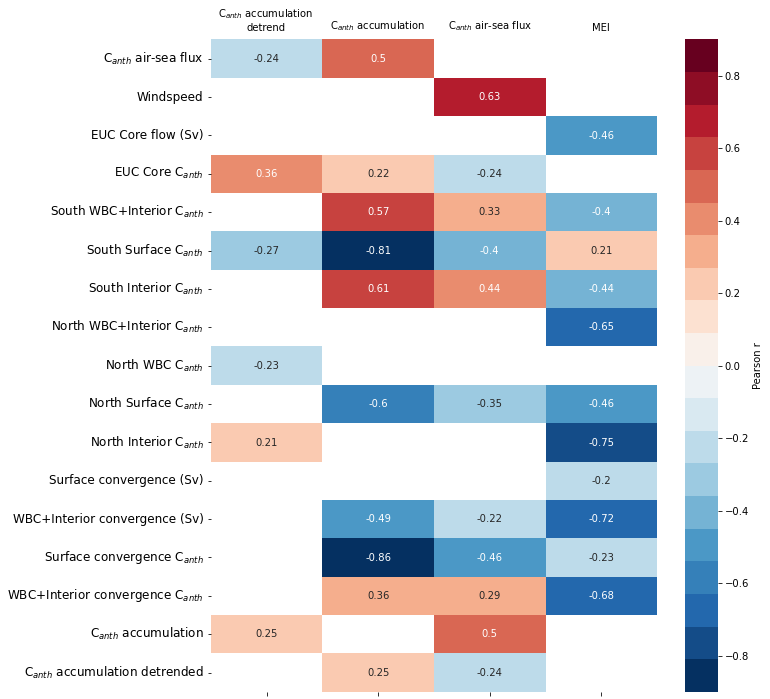

In [148]:
corr=corr_ds_extra_loaded1.to_dataframe().corr()


mini_corr=corr.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI']].replace(1,np.nan).T #anth_
mini_corr=mini_corr.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend'},axis=1)
#annots=mini_corr
mini_corr=mini_corr.where(abs(mini_corr)>0.2).dropna(thresh=1)
plt.figure(figsize=(10,12))
cmap = cm.get_cmap('RdBu_r', 20)
my_cmap = cmap
my_cmap.set_under("grey")

sns.heatmap(mini_corr,annot=True,cmap=cmap,vmin=-0.9,vmax=0.9,cbar_kws={'label': 'Pearson r'})#,mask=trimask)


plt.xticks(rotation=320,ha='left',fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labelbottom=False,labeltop=True)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

In [149]:
corr=corr_ds_extra_loaded1.to_dataframe().corr()

## Pittman STC Figure 6

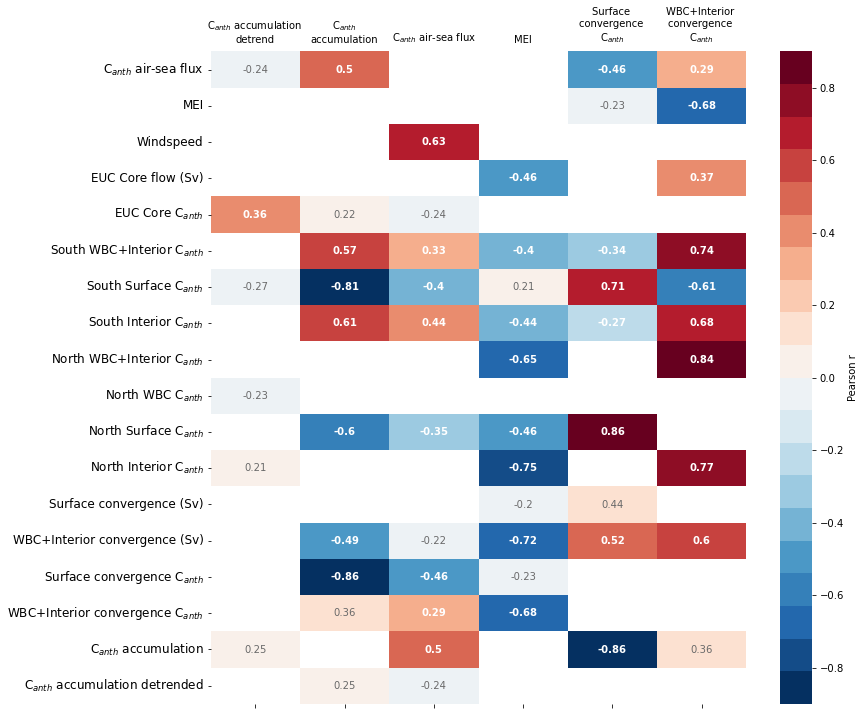

In [154]:

corr=corr_ds_extra_loaded1.to_dataframe().corr()

mini_corr=corr.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI','Surface convergence C$_{anth}$','WBC+Interior convergence C$_{anth}$']].replace(1,np.nan).T #anth_
mini_corr=mini_corr.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend',
                            'C$_{anth}$ accumulation':'C$_{anth}$ \naccumulation',
                            'Surface convergence C$_{anth}$':'Surface \nconvergence \nC$_{anth}$',
                            'WBC+Interior convergence C$_{anth}$': 'WBC+Interior \nconvergence \nC$_{anth}$'},axis=1)

#mini_core=corr#.corr()
#annots=mini_corr
mini_corr=mini_corr.where(abs(mini_corr)>0.2).dropna(thresh=1)

df=corr#.drop(['lon','yt_ocean'],axis=0)
pvals=df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(df.columns))#.drop(['lon','yt_ocean'],axis=0)


mini_pvals=pvals.loc[['C$_{anth}$ accumulation detrended','C$_{anth}$ accumulation','C$_{anth}$ air-sea flux','MEI','Surface convergence C$_{anth}$','WBC+Interior convergence C$_{anth}$']].replace(1,np.nan).T #anth_
mini_pvals=mini_pvals.rename({'C$_{anth}$ accumulation detrended':'C$_{anth}$ accumulation \ndetrend',
                            'C$_{anth}$ accumulation':'C$_{anth}$ \naccumulation',
                            'Surface convergence C$_{anth}$':'Surface \nconvergence \nC$_{anth}$',
                            'WBC+Interior convergence C$_{anth}$': 'WBC+Interior \nconvergence \nC$_{anth}$'},axis=1)
#significant_values=~np.isnan(pvals.where(pvals<0.05))


plt.figure(figsize=(12,12))
cmap = cm.get_cmap('RdBu_r', 20)
my_cmap = cmap
my_cmap.set_under("grey")


sns.heatmap(mini_corr,annot=True,cmap=cmap,vmin=-0.9,vmax=0.9,cbar_kws={'label': 'Pearson r'},annot_kws={"weight": "bold",'color':'white'},mask=mini_pvals.drop(['lon','yt_ocean','South WBC C$_{anth}$'],axis=0).dropna(thresh=1)>0.05)#)#,mask=trimask)
sns.heatmap(mini_corr,annot=True, annot_kws={'color':'dimgray'},cmap=cmap,vmin=-3,vmax=3, cbar=False,mask=mini_pvals.drop(['lon','yt_ocean','South WBC C$_{anth}$'],axis=0).dropna(thresh=1)<0.05)#)#,mask=trimask)

plt.xticks(rotation=320,ha='left',fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labelbottom=False,labeltop=True)
#plt.colorbar()
#_=plt.xticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns,rotation=310)
#_=plt.yticks(np.arange(0,len(corr_df_extra.columns),1),corr_df_extra.columns)

In [155]:
mini_corr

C$_{anth}$ accumulation \ndetrend  \
C$_{anth}$ air-sea flux                                      -0.235920   
MEI                                                                NaN   
Windspeed                                                          NaN   
EUC Core flow (Sv)                                                 NaN   
EUC Core C$_{anth}$                                           0.361297   
South WBC+Interior C$_{anth}$                                      NaN   
South Surface C$_{anth}$                                     -0.272357   
South Interior C$_{anth}$                                          NaN   
North WBC+Interior C$_{anth}$                                      NaN   
North WBC C$_{anth}$                                         -0.232155   
North Surface C$_{anth}$                                           NaN   
North Interior C$_{anth}$                                     0.211757   
Surface convergence (Sv)                                           NaN   
WBC+Interior convergence (Sv)                                      NaN   
Surface convergence C$_{anth}$                                     NaN   
WBC+Interior convergence C$_{anth}$                                NaN   
C$_{anth}$ accumulation                                       0.250328   
C$_{anth}$ accumulation detrended                                  NaN   

                                     C$_{anth}$ \naccumulation  \
C$_{anth}$ air-sea flux                               0.498141   
MEI                                                        NaN   
Windspeed                                                  NaN   
EUC Core flow (Sv)                                         NaN   
EUC Core C$_{anth}$                                   0.220259   
South WBC+Interior C$_{anth}$                         0.565024   
South Surface C$_{anth}$                             -0.811877   
South Interior C$_{anth}$                             0.605264   
North WBC+Interior C$_{anth}$                              NaN   
North WBC C$_{anth}$                                       NaN   
North Surface C$_{anth}$                             -0.603760   
North Interior C$_{anth}$                                  NaN   
Surface convergence (Sv)                                   NaN   
WBC+Interior convergence (Sv)                        -0.493452   
Surface convergence C$_{anth}$                       -0.864448   
WBC+Interior convergence C$_{anth}$                   0.355640   
C$_{anth}$ accumulation                                    NaN   
C$_{anth}$ accumulation detrended                     0.250328   

                                     C$_{anth}$ air-sea flux       MEI  \
C$_{anth}$ air-sea flux                                  NaN       NaN   
MEI                                                      NaN       NaN   
Windspeed                                           0.634594       NaN   
EUC Core flow (Sv)                                       NaN -0.455863   
EUC Core C$_{anth}$                                -0.241974       NaN   
South WBC+Interior C$_{anth}$                       0.326625 -0.400898   
South Surface C$_{anth}$                           -0.395783  0.209277   
South Interior C$_{anth}$                           0.439126 -0.444811   
North WBC+Interior C$_{anth}$                            NaN -0.652181   
North WBC C$_{anth}$                                     NaN       NaN   
North Surface C$_{anth}$                           -0.351162 -0.463858   
North Interior C$_{anth}$                                NaN -0.748312   
Surface convergence (Sv)                                 NaN -0.201274   
WBC+Interior convergence (Sv)                      -0.223633 -0.718168   
Surface convergence C$_{anth}$                     -0.462726 -0.227500   
WBC+Interior convergence C$_{anth}$                 0.291760 -0.680435   
C$_{anth}$ accumulation                             0.498141       NaN   
C$_{anth}$ accumulation detrended          

In [156]:
mini_pvals#.shape

C$_{anth}$ accumulation \ndetrend  \
C$_{anth}$ air-sea flux                                                 0.472204   
MEI                                                                     0.655651   
Windspeed                                                               0.309373   
lon                                                                          NaN   
EUC Core flow (Sv)                                                      0.225024   
EUC Core C$_{anth}$                                                     0.005203   
yt_ocean                                                                     NaN   
South WBC+Interior C$_{anth}$                                           0.144256   
South WBC C$_{anth}$                                                    0.187628   
South Surface C$_{anth}$                                                0.093517   
South Interior C$_{anth}$                                               0.403985   
North WBC+Interior C$_{anth}$                                           0.719003   
North WBC C$_{anth}$                                                    0.074741   
North Surface C$_{anth}$                                                0.756251   
North Interior C$_{anth}$                                               0.219865   
Surface convergence (Sv)                                                0.395535   
WBC+Interior convergence (Sv)                                           0.814513   
Surface convergence C$_{anth}$                                          0.299689   
WBC+Interior convergence C$_{anth}$                                     0.320002   
Surface convergence C$_{anth}$ detrended                                     NaN   
WBC+Interior convergence C$_{anth}$ detrended                                NaN   
C$_{anth}$ accumulation                                                 0.185325   
C$_{anth}$ accumulation detrended                                       0.000000   

                                               C$_{anth}$ \naccumulation  \
C$_{anth}$ air-sea flux                                     4.117434e-04   
MEI                                                         8.143671e-01   
Windspeed                                                   5.601251e-01   
lon                                                                  NaN   
EUC Core flow (Sv)                                          9.210386e-01   
EUC Core C$_{anth}$                                         1.967177e-01   
yt_ocean                                                             NaN   
South WBC+Interior C$_{anth}$                               7.158792e-04   
South WBC C$_{anth}$                                        8.132789e-01   
South Surface C$_{anth}$                                    3.758401e-08   
South Interior C$_{anth}$                                   7.436319e-04   
North WBC+Interior C$_{anth}$                               6.816542e-01   
North WBC C$_{anth}$                                        9.178242e-01   
North Surface C$_{anth}$                                    3.076557e-04   
North Interior C$_{anth}$                                   7.472885e-01   
Surface convergence (Sv)                                    6.608318e-01   
WBC+Interior convergence (Sv)                               2.964396e-02   
Surface convergence C$_{anth}$                              1.044465e-09   
WBC+Interior convergence C$_{anth}$                         5.869179e-02   
Surface convergence C$_{anth}$ detrended                             NaN   
WBC+Interior convergence C$_{anth}$ detrended                        NaN   
C$_{anth}$ accumulation                                     0.000000e+00   
C$_{anth}$ accumulation detrended                           1.853250e-01   

                                               C$_{anth}$ air-sea flux  \
C$_{anth}$ air-sea flux                                       0.000000   
MEI                                                      

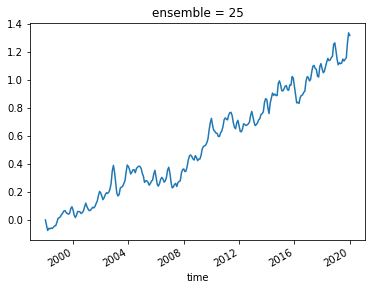

In [160]:
canth_300m_in_box_1998.plot()

In [161]:
surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18


surf_anth=((anthymertrans_surfaceN_seasonal+anthymertrans_surfaceS_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18
subsurf_anth=((anthymertrans_WBCsubsurfaceS_seasonal+anthymertrans_WBCsubsurfaceN_seasonal)).sel(time=slice('1998','2020'))#*60*60*24*365*12)/1e18



#upwelling1=((anthupwelling.sel(time=slice('1998','2019-12-31'),lat=slice(-5,5),lon=slice(160,300)).sum(['lat','lon']).sel(st_ocean=-300,method='nearest')*60*60*24*365*12)/1e18)
surface_out=(anth_surface_seasonal)#*60*60*24*365*12)/1e18#).sum(['lat','lon'])
wbc_in=((anthymertrans_wbcS+anthymertrans_wbcN))#*60*60*24*365*12)/1e18#.sum(['lat','lon']#)
wbcsubsurface_in=((anthymertrans_WBCsubsurfaceS+anthymertrans_WBCsubsurfaceN))#*60*60*24*365*12)/1e18
interior_in=((anthymertrans_subsurfaceS+anthymertrans_subsurfaceN))#*60*60*24*365*12)/1e18#.sum(['lat','lon'])
euc_in=itf_canth#((anth_dic_u_tx.sel(lat=slice(-5,5),st_ocean=slice(0,-600)).sel(lon=124,method='nearest').sum(dim=['st_ocean','lat'])*60*60*24*365*12)/1e18)#.plot() #.rolling(time=12,center=True).mean()

In [162]:
(canth_in_box_1998).rolling(time=12,center=True).mean().mean()/20#plot(c='k')
#(canth_in_box_1998).plot(c='k',linestyle=":")
(canth_300m_in_box_1998).mean()/20#.plot(c='r',linestyle=':')

<xarray.DataArray ()>
array(0.02682016)
Coordinates:
    ensemble  int32 25

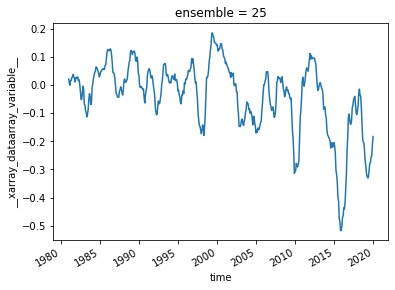

In [165]:
((surface_out+wbcsubsurface_in)).rolling(time=12,center=True).mean().plot()#.cumsum()/12).plot()

In [ ]:
canth_in_box_1998.mean()/20#.mean()

<xarray.DataArray ()>
array(0.03598964)
Coordinates:
    ensemble  int32 25

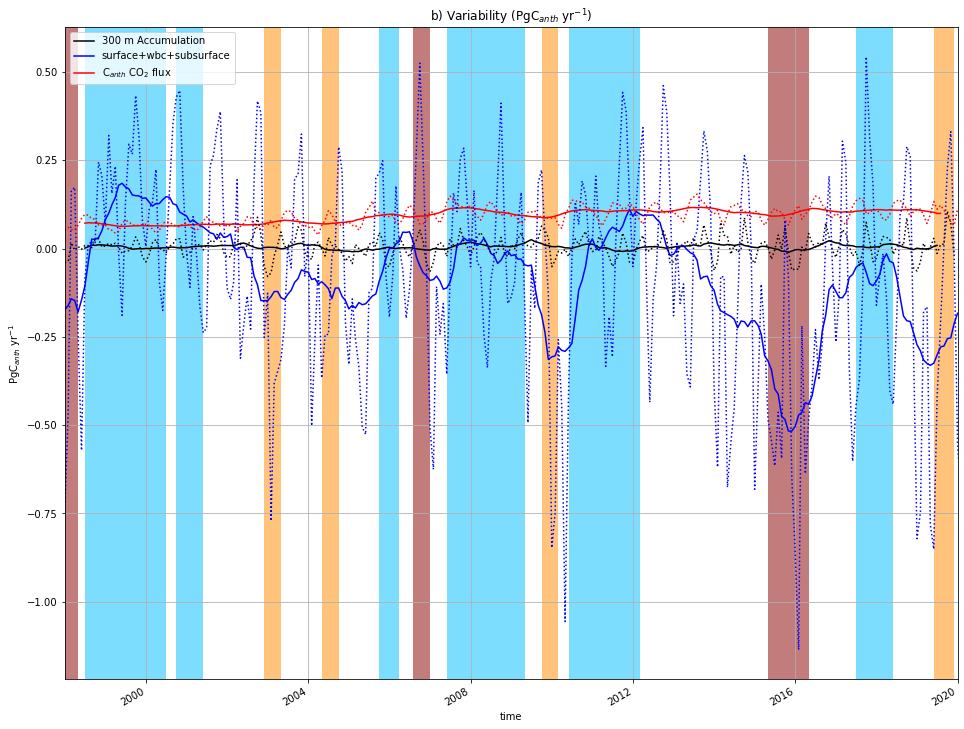

In [169]:
plt.figure(figsize=(16,12))# New Simpler Figure

ax=plt.subplot(111)

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
((canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).rolling(time=12, center=True)).mean().plot(c='k')
#((canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).rolling(time=12,center=True)).mean().plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
(((surface_out+wbcsubsurface_in).rolling(time=12, center=True)).mean().sel(time=slice('1998','2020'))).plot(c='blue')
(((co2.rolling(time=12,center=True)).mean()).sel(time=slice('1998','2020'))).plot(c='r')
#((itf_canth.rolling(time=12, center=True)).mean()).plot(c='m')

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
(canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).plot(c='k',linestyle=':',label='__nolegend__')
#(canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).plot(c='red',linestyle=':',label='__nolegend__')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020'))).plot(c='blue',linestyle=':',label='__nolegend__')
((co2).sel(time=slice('1998','2020'))).plot(c='r',linestyle=':',label='__nolegend__')
#(itf_canth).plot(c='m',linestyle=':',label='__nolegend__')

add_enso_colours(ax)
#.rolling(time=12,center=True)).mean()
plt.title('b) Variability (PgC$_{{anth}}$ yr$^{-1}$)')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
plt.legend(['300 m Accumulation', 'surface+wbc+subsurface','C$_{anth}$ CO$_{2}$ flux'])# 'surf+subsurf+wbc+co2'
plt.grid()

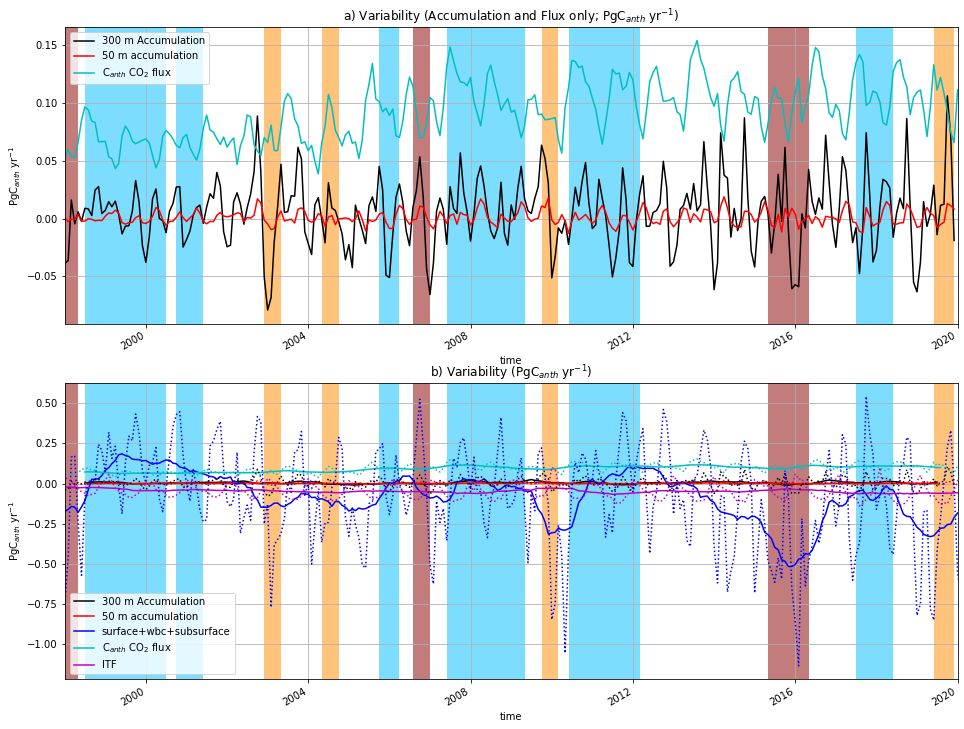

In [170]:
# 50 m accumulation
# 300 m accumulation
# #Air sea flux accumulation
# surf+subsurf+wbc
plt.figure(figsize=(16,12))

ax=plt.subplot(211)

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
(canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).plot(c='k')
(canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
#((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020'))).plot(c='blue')
((co2).sel(time=slice('1998','2020'))).plot(c='c')
plt.title('a) Variability (Accumulation and Flux only; PgC$_{{anth}}$ yr$^{-1}$)')
#(itf_canth).plot(c='cyan')
#.rolling(time=12,center=True)).mean()
 
add_enso_colours(ax)
plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
plt.legend(['300 m Accumulation', '50 m accumulation','C$_{anth}$ CO$_{2}$ flux'])# 'surf+subsurf+wbc+co2'
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.grid()

#ax=plt.subplot(412)

ax=plt.subplot(212)

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
((canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).rolling(time=12, center=True)).mean().plot(c='k')
((canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).rolling(time=12,center=True)).mean().plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
(((surface_out+wbcsubsurface_in).rolling(time=12, center=True)).mean().sel(time=slice('1998','2020'))).plot(c='blue')
(((co2.rolling(time=12,center=True)).mean()).sel(time=slice('1998','2020'))).plot(c='c')
((itf_canth.rolling(time=12, center=True)).mean()).plot(c='m')

# plot accumulations first but also plot the second derivative
#(canth_in_box_1998.shift(time=-1)-canth_in_box_1998).plot(c='k')
(canth_300m_in_box_1998.shift(time=-1)-canth_300m_in_box_1998).plot(c='k',linestyle=':',label='__nolegend__')
(canth_50m_in_box_1998.shift(time=-1)-canth_50m_in_box_1998).plot(c='red',linestyle=':',label='__nolegend__')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020'))).plot(c='m')
((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020'))).plot(c='blue',linestyle=':',label='__nolegend__')
((co2).sel(time=slice('1998','2020'))).plot(c='c',linestyle=':',label='__nolegend__')
(itf_canth).plot(c='m',linestyle=':',label='__nolegend__')

add_enso_colours(ax)
#.rolling(time=12,center=True)).mean()
plt.title('b) Variability (PgC$_{{anth}}$ yr$^{-1}$)')
plt.ylabel('PgC$_{anth}$ yr$^{-1}$')
plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
plt.legend(['300 m Accumulation', '50 m accumulation','surface+wbc+subsurface','C$_{anth}$ CO$_{2}$ flux','ITF'])# 'surf+subsurf+wbc+co2'
plt.grid()

#ax=plt.subplot(313)
## plot accumulations first but also plot the second derivative
#(canth_in_box_1998).plot(c='lime')
#(canth_300m_in_box_1998).plot(c='k')
#canth_50m_in_box_1998.plot(c='red')
#((surface_out+wbcsubsurface_in+co2).sel(time=slice('1998','2020')).cumsum()/12).plot(c='darkorange')
#((surface_out+wbcsubsurface_in).sel(time=slice('1998','2020')).cumsum()/12).plot(c='blue')
#((co2).sel(time=slice('1998','2020')).cumsum()/12).plot(c='c')
#(itf_canth.sel(time=slice('1998','2020')).cumsum()/12).plot(c='m')
#plt.title('Accumulation (PgC$_{{anth}}$  since 1998 )')
#add_enso_colours(ax)
#plt.legend(['Accumulation','300m Accumulation', '50m accumulation', 'surf+subsurf+wbc+co2','surface+wbc+subsurface','co2 flux','ITF'],ncol=7)
#plt.xlim([np.datetime64('1998'),np.datetime64('2020')])
#plt.ylabel('PgC$_{anth}$ since 1998')
#plt.grid()
#plt.tight_layout()